
- Blockchain Censorship * 
- Ethereum’s Proposer-Builder Separation: Promises and Realities *
- Blockchain Transaction Censorship:  (In)secure and (In)efficient? 
- From Competition to Centralization: The Oligopoly in Ethereum Block Building Auctions
- Block and Transaction Delivery in Ethereum Network
- Regulating decentralized systems: evidence from sanctions on Tornado Cash
- Agent-Based Modelling of Ethereum Consensus
- Understanding decentralization of decisionmaking power in proof-of-stake blockchains: an agent-based simulation approach


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import ast
import itertools
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

#### Transaction Delay

In [2]:
# Load the first dataset (non-censorship scenario)
file_path1 = "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/transactions.csv"
transactions1 = pd.read_csv(file_path1)
transactions1 = transactions1[transactions1['is_proposed']].copy()
transactions1['proposal_delay'] = transactions1['proposed_time'] - transactions1['arrival_time']
transactions1['sanctioned_type'] = transactions1['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
transactions1['experiment'] = 'b0_s0_r0_v0'

# Load the second dataset (censorship scenario)
file_path2 = "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/transactions.csv"
transactions2 = pd.read_csv(file_path2)
transactions2 = transactions2[transactions2['is_proposed']].copy()
transactions2['proposal_delay'] = transactions2['proposed_time'] - transactions2['arrival_time']
transactions2['sanctioned_type'] = transactions2['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
transactions2['experiment'] = 'b5_s5_r5_v2'

# Combine the two datasets
combined_transactions = pd.concat([transactions1, transactions2], ignore_index=True)

# Check for negative proposal delays
negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)

# Average within each run first, then average across runs
# Step 1: Compute mean and standard deviation for each run, experiment, and sanctioned type
run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()

# Step 2: Compute the average of the means and stds across runs, for each experiment and sanctioned type
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

[0 rows x 23 columns]
Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
    experiment     sanctioned_type       mean        std
0  b0_s0_r0_v0  Non-sanctioned (0)  15.491090  12.318609
1  b0_s0_r0_v0      Sanctioned (1)  15.619994  11.674493
2  b5_s5_r5_v2  Non-sanctioned (0)  17.155240  15.481839
3  b5_s5_r5_v2      Sanctioned (1)  29.286784  62.228970


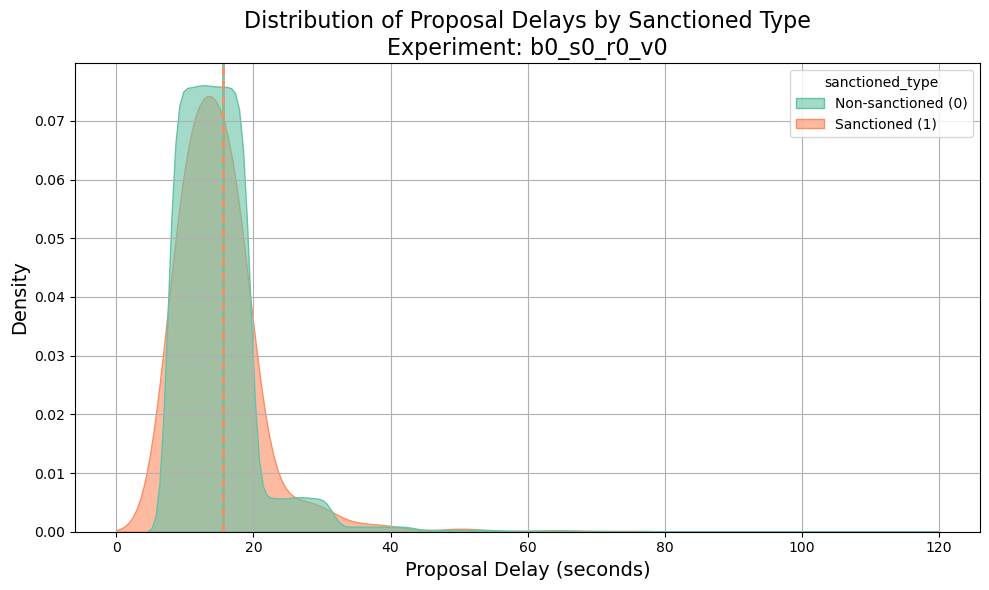

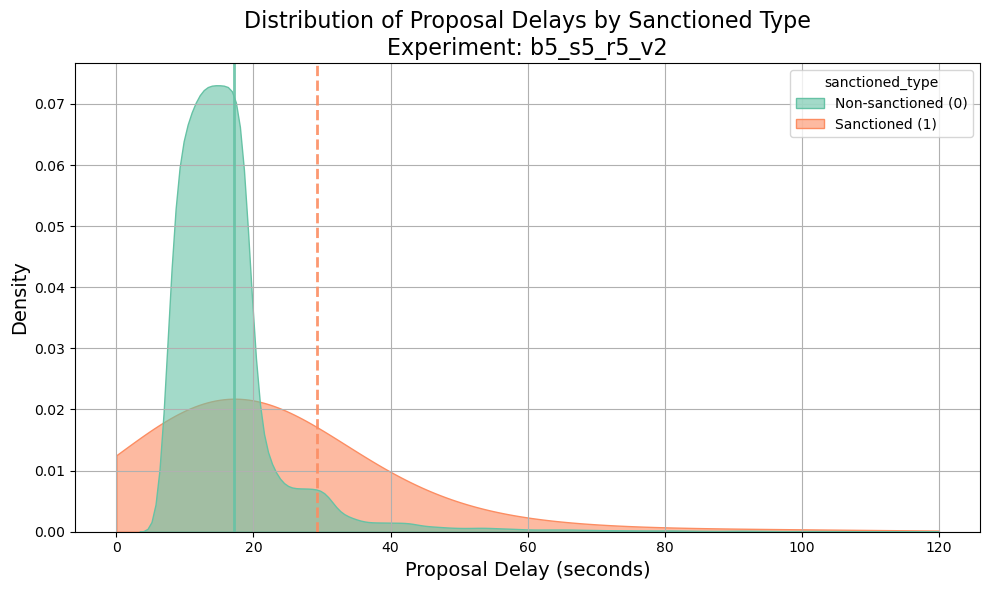

In [3]:

color_palette = sns.color_palette("Set2")
colors = {
    'Non-sanctioned (0)': color_palette[0],
    'Sanctioned (1)': color_palette[1]
}

linestyles = {
    'Non-sanctioned (0)': 'solid',
    'Sanctioned (1)': 'dashed'
}

for exp in combined_transactions['experiment'].unique():
    plt.figure(figsize=(10, 6))
    subset_data = combined_transactions[combined_transactions['experiment'] == exp]

    # KDE plot
    sns.kdeplot(
        data=subset_data,
        x='proposal_delay',
        hue='sanctioned_type',
        fill=True,
        common_norm=False,
        palette=colors,
        alpha=0.6,
        clip=(0, 120)
    )

    # Add vertical lines for the mean
    for stype in subset_data['sanctioned_type'].unique():
        mean_value = final_stats[
            (final_stats['experiment'] == exp) & 
            (final_stats['sanctioned_type'] == stype)
        ]['mean'].values[0]

        plt.axvline(
            mean_value,
            linestyle=linestyles[stype],
            linewidth=2,
            color=colors[stype],
            alpha=0.9  
        )

    plt.xlabel('Proposal Delay (seconds)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Distribution of Proposal Delays by Sanctioned Type\nExperiment: {exp}', fontsize=16)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


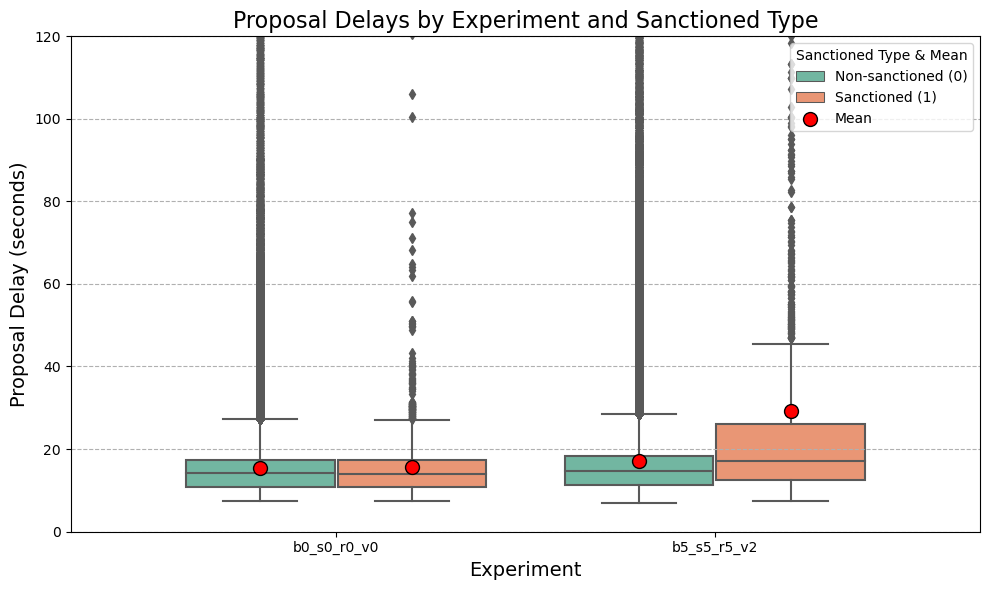

In [4]:
# Assume combined_transactions and final_stats already exist
# Structure of final_stats:
# experiment | sanctioned_type | mean | std
# The mean in this plot is based on per-run averages, then averaged across runs

plt.figure(figsize=(10, 6))

# Draw boxplot first
ax = sns.boxplot(
    x='experiment', 
    y='proposal_delay', 
    hue='sanctioned_type', 
    data=combined_transactions, 
    palette='Set2'
)


# Get boxplot positions (ticks are at 0 and 1 for two experiments)
positions = {'b0_s0_r0_v0': 0, 'b5_s5_r5_v2': 1}
offset = {'Non-sanctioned (0)': -0.2, 'Sanctioned (1)': 0.2}

# Overlay the mean as red scatter points
for idx, row in final_stats.iterrows():
    x_pos = positions[row['experiment']] + offset[row['sanctioned_type']]
    plt.scatter(
        x=x_pos, 
        y=row['mean'], 
        color='red', 
        edgecolor='black', 
        s=100,
        zorder=5,
        label='Mean' if idx == 0 else ""
    )

# Add legend if not already included
handles, labels = ax.get_legend_handles_labels()
if 'Mean' not in labels:
    handles.append(plt.Line2D([], [], color='red', marker='o', linestyle='', markersize=10, label='Mean'))
    labels.append('Mean')

plt.legend(handles=handles, labels=labels, title='Sanctioned Type & Mean', loc='upper right')

# Set additional plot parameters
plt.xlabel('Experiment', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Proposal Delays by Experiment and Sanctioned Type', fontsize=16)
plt.ylim(0, 120)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


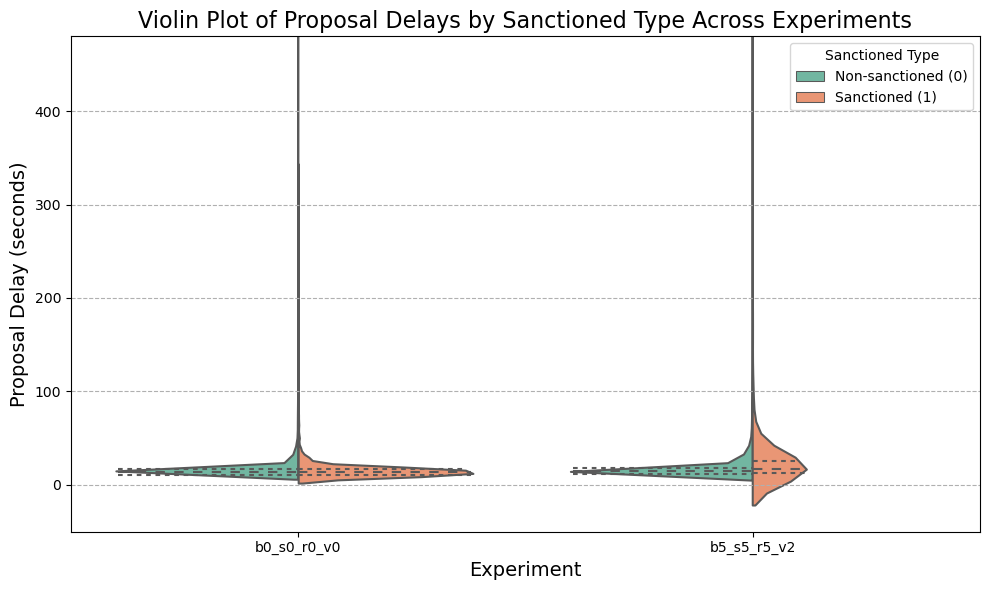

In [5]:

# Plot violin chart
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=combined_transactions,
    x='experiment',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)

# Set y-axis range
plt.ylim(-50, 480)

# Title and axis labels
plt.xlabel('Experiment', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays by Sanctioned Type Across Experiments', fontsize=16)
plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

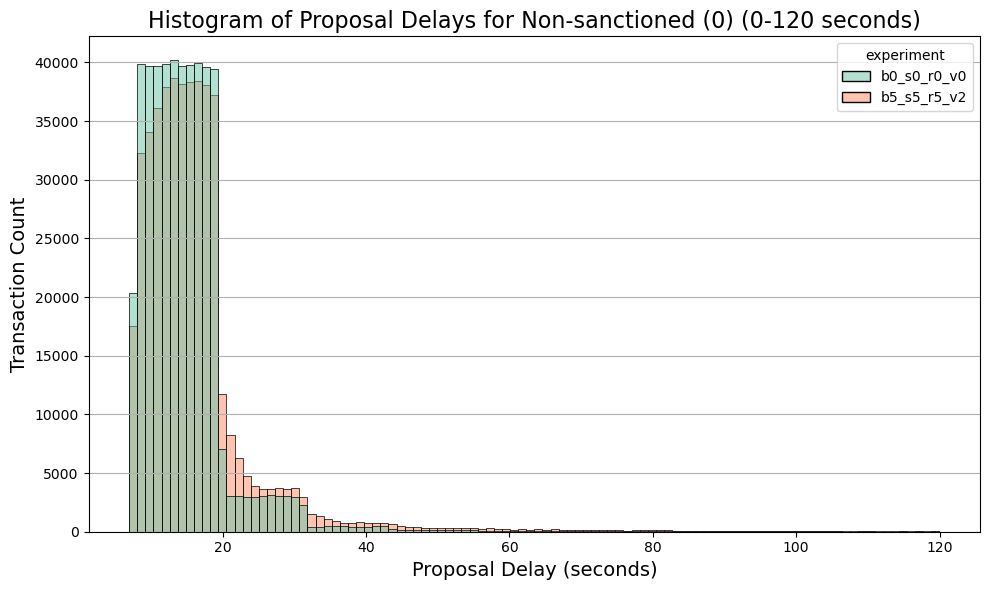

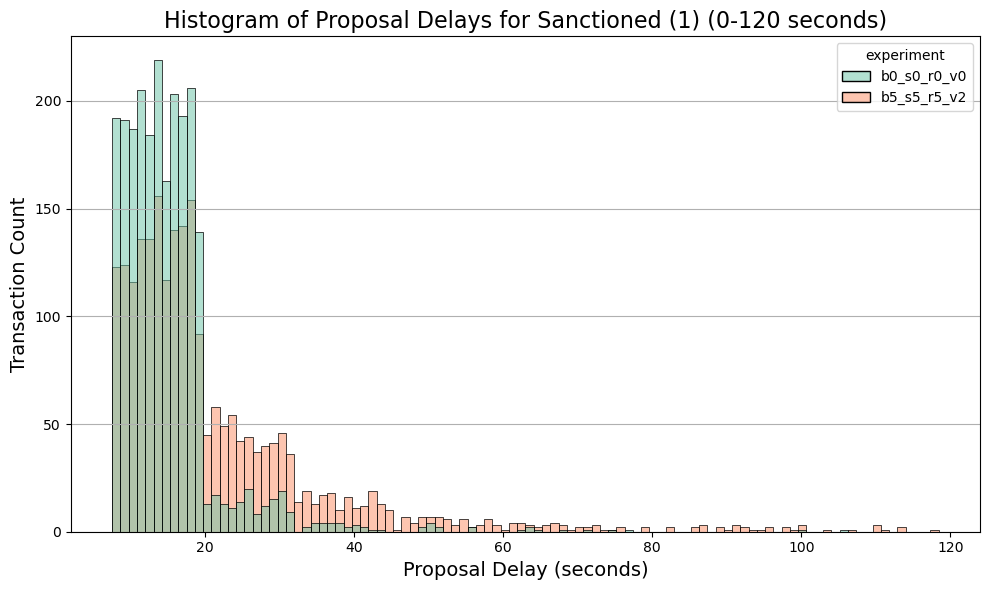

In [6]:

# Filter transactions with proposal_delay between 0 and 120 seconds
filtered_txs = combined_transactions[
    (combined_transactions['proposal_delay'] >= 0) & 
    (combined_transactions['proposal_delay'] <= 120)
]

# Plot histogram for each sanctioned type
for sanctioned in ['Non-sanctioned (0)', 'Sanctioned (1)']:
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=filtered_txs[filtered_txs['sanctioned_type'] == sanctioned],
        x='proposal_delay',
        hue='experiment',
        multiple='layer',
        palette='Set2',
        bins=100,
        edgecolor='black',
        alpha=0.5
    )

    plt.xlabel('Proposal Delay (seconds)', fontsize=14)
    plt.ylabel('Transaction Count', fontsize=14)
    plt.title(f'Histogram of Proposal Delays for {sanctioned} (0-120 seconds)', fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


### Compute average proposal delays of sanctioned and non-sanctioned transactions per slot


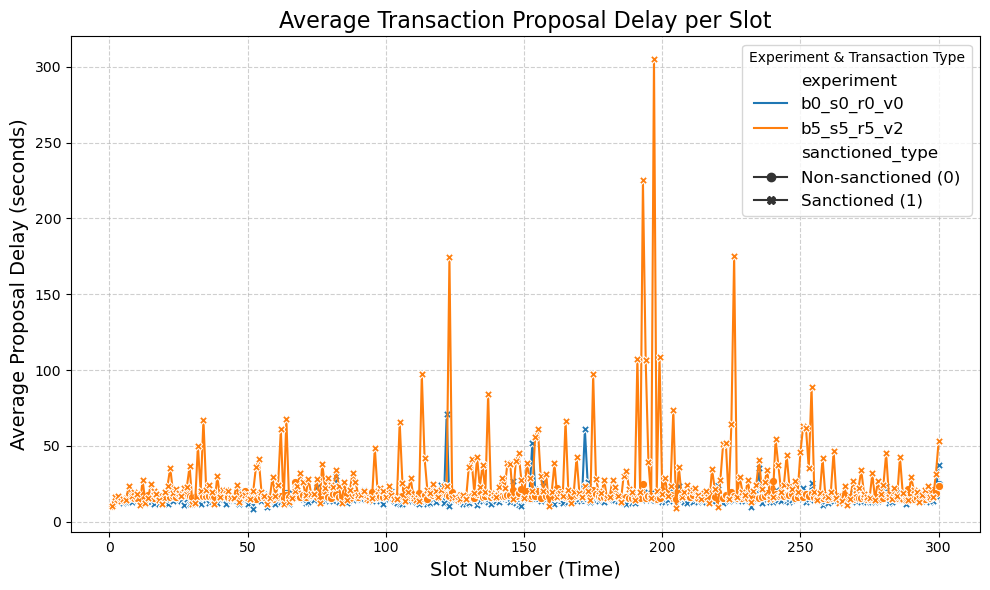

In [7]:


# Function to load and preprocess transaction data
def load_and_prepare(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[df['is_proposed']].copy()
    df['proposal_delay'] = df['proposed_time'] - df['arrival_time']
    df['sanctioned_type'] = df['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    df['experiment'] = experiment_label
    df['slot'] = ((df['proposed_time'] - 1) // 12).astype(int)  
    return df

# Load the two datasets
transactions1 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/transactions.csv", 
    'b0_s0_r0_v0'
)

transactions2 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/transactions.csv", 
    'b5_s5_r5_v2'
)

# Combine the datasets
combined_transactions = pd.concat([transactions1, transactions2], ignore_index=True)

# Step 1: Compute average delay per run_id, experiment, slot, and transaction type
slot_run_stats = combined_transactions.groupby(
    ['experiment', 'run_id', 'slot', 'sanctioned_type']
)['proposal_delay'].mean().reset_index(name='mean_delay')

# Step 2: Average over runs for each slot and transaction type
slot_avg_stats = slot_run_stats.groupby(
    ['experiment', 'slot', 'sanctioned_type']
)['mean_delay'].mean().reset_index()

# Plot average delay across slots for all types
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=slot_avg_stats,
    x='slot',
    y='mean_delay',
    hue='experiment',
    style='sanctioned_type',
    markers=True,
    dashes=False
)

plt.xlabel("Slot Number (Time)", fontsize=14)
plt.ylabel("Average Proposal Delay (seconds)", fontsize=14)
plt.title("Average Transaction Proposal Delay per Slot", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Experiment & Transaction Type", fontsize=12)
plt.tight_layout()
plt.show()


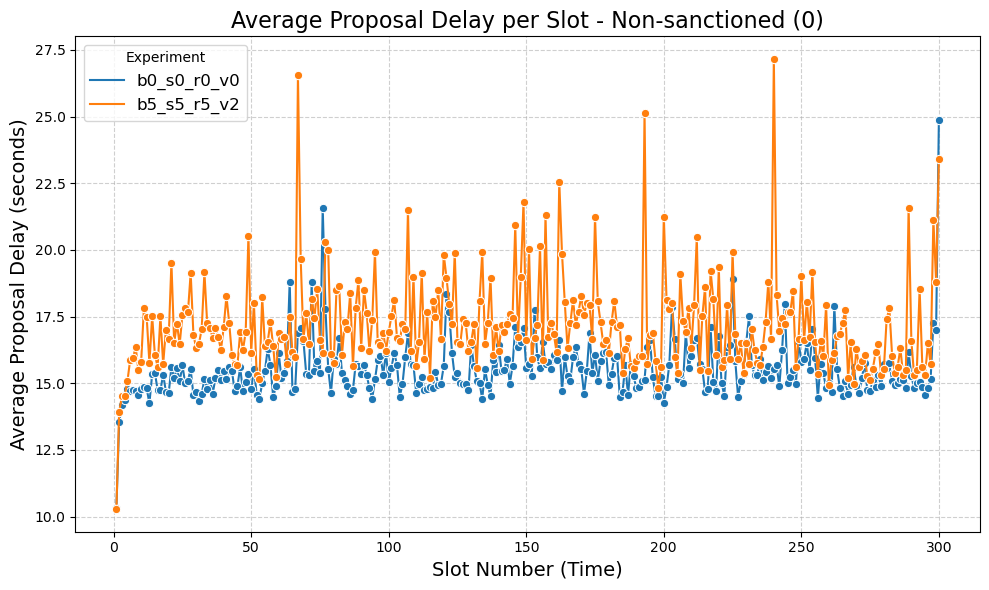

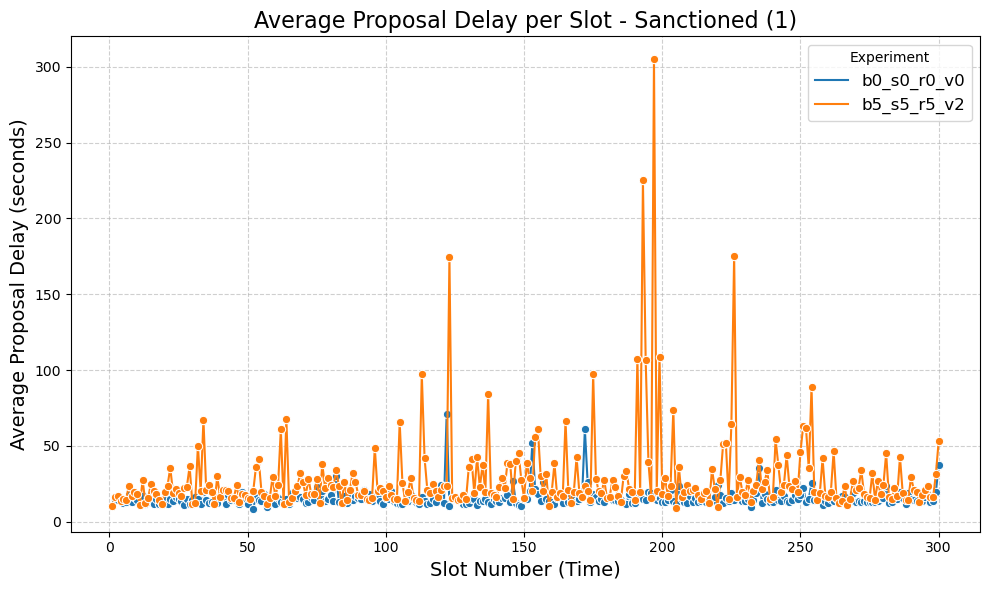

In [8]:


# Combine the datasets
combined_transactions = pd.concat([transactions1, transactions2], ignore_index=True)

# Step 1: Compute average delay per run_id, experiment, slot, and transaction type
slot_run_stats = combined_transactions.groupby(
    ['experiment', 'run_id', 'slot', 'sanctioned_type']
)['proposal_delay'].mean().reset_index(name='mean_delay')

# Step 2: Average over runs for each slot and transaction type
slot_avg_stats = slot_run_stats.groupby(
    ['experiment', 'slot', 'sanctioned_type']
)['mean_delay'].mean().reset_index()

# Plot separate figures for each transaction type
transaction_types = slot_avg_stats['sanctioned_type'].unique()

for tx_type in transaction_types:
    plt.figure(figsize=(10, 6))
    subset = slot_avg_stats[slot_avg_stats['sanctioned_type'] == tx_type]

    sns.lineplot(
        data=subset,
        x='slot',
        y='mean_delay',
        hue='experiment',
        marker='o'
    )

    plt.xlabel("Slot Number (Time)", fontsize=14)
    plt.ylabel("Average Proposal Delay (seconds)", fontsize=14)
    plt.title(f"Average Proposal Delay per Slot - {tx_type}", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Experiment", fontsize=12)
    plt.tight_layout()
    plt.show()


#### Calculate the cumulative average proposal delay of TC and non-TC transactions up to each slot as time progresses.

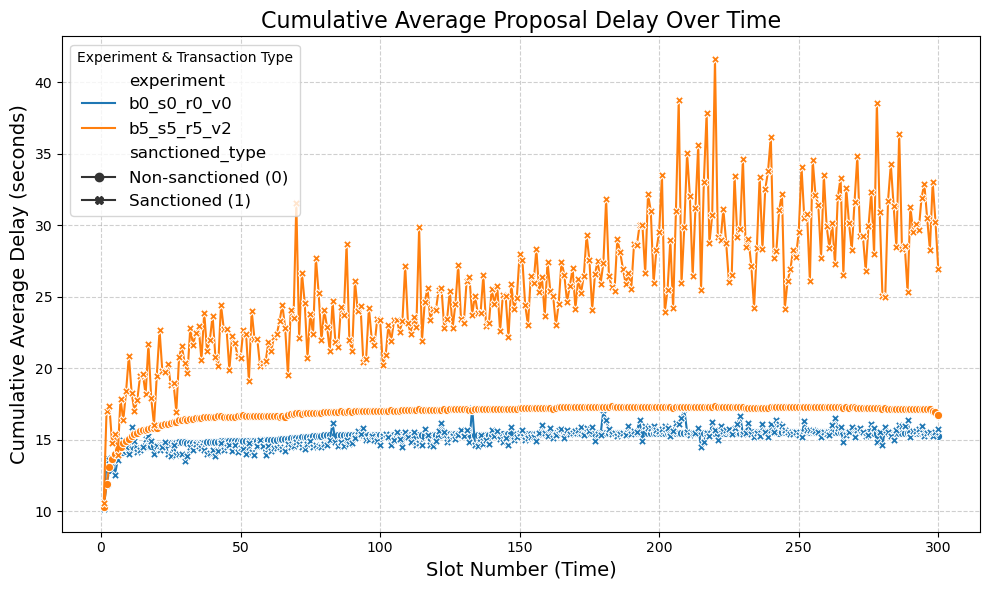

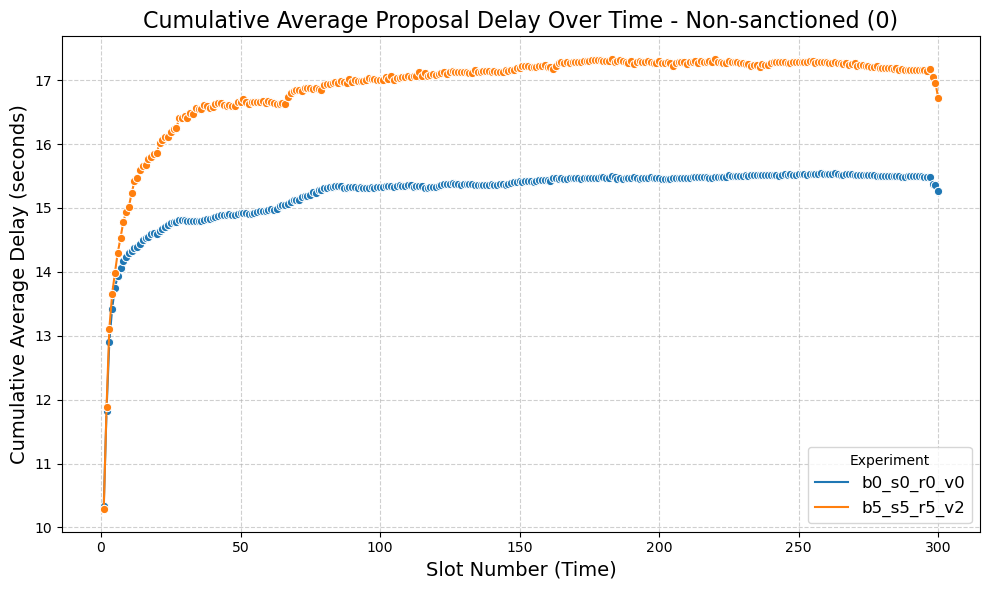

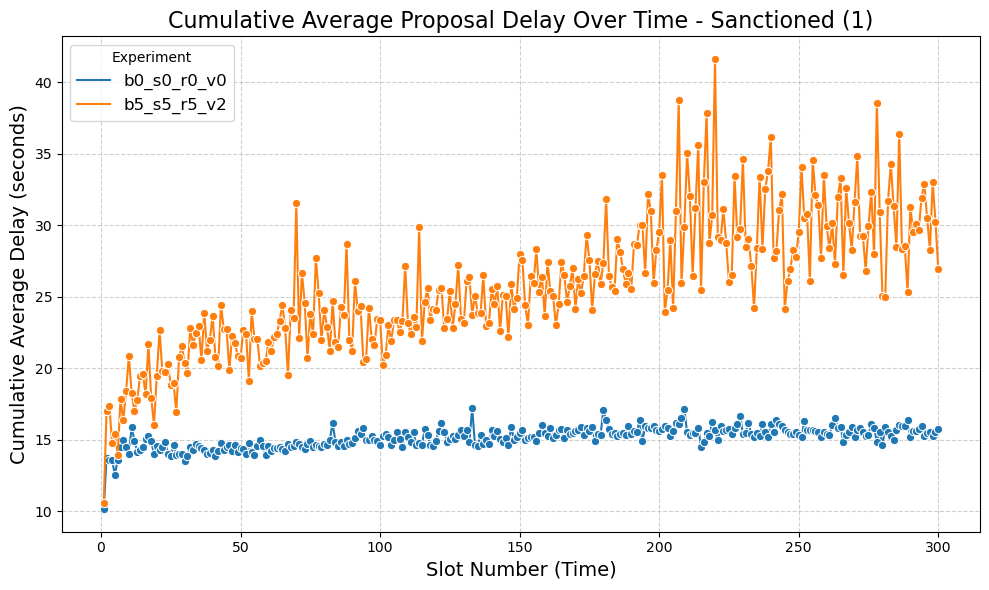

In [9]:


# Data loading function
def load_and_prepare(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[df['is_proposed']].copy()
    df['proposal_delay'] = df['proposed_time'] - df['arrival_time']
    df['sanctioned_type'] = df['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    df['experiment'] = experiment_label
    df['slot'] = ((df['proposed_time'] - 1) // 12).astype(int)
    return df

# Load two datasets
transactions1 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/transactions.csv", 
    'b0_s0_r0_v0'
)

transactions2 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/transactions.csv", 
    'b5_s5_r5_v2'
)

# Combine datasets
combined_transactions = pd.concat([transactions1, transactions2], ignore_index=True)

# Store cumulative statistics for each group
cumulative_results = []

# Compute cumulative average delay per (experiment, run_id, transaction type) group
for (experiment, run_id, sanctioned_type), group in combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type']):
    group_sorted = group.sort_values('slot')
    group_sorted['cumulative_mean_delay'] = group_sorted['proposal_delay'].expanding().mean()
    cumulative_results.append(group_sorted[['experiment', 'run_id', 'sanctioned_type', 'slot', 'cumulative_mean_delay']])

# Combine all cumulative results
cumulative_df = pd.concat(cumulative_results)

# Then compute the average cumulative delay across all runs
final_cumulative_stats = cumulative_df.groupby(['experiment', 'slot', 'sanctioned_type'])['cumulative_mean_delay'].mean().reset_index()

# Plot cumulative delay curves for sanctioned and non-sanctioned transactions
transaction_types = final_cumulative_stats['sanctioned_type'].unique()


plt.figure(figsize=(10, 6))

# Use different line styles to distinguish sanctioned_type and experiment
sns.lineplot(
    data=final_cumulative_stats,
    x='slot',
    y='cumulative_mean_delay',
    hue='experiment',
    style='sanctioned_type',
    markers=True,
    dashes=False
)

plt.xlabel("Slot Number (Time)", fontsize=14)
plt.ylabel("Cumulative Average Delay (seconds)", fontsize=14)
plt.title("Cumulative Average Proposal Delay Over Time", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Experiment & Transaction Type", fontsize=12)
plt.tight_layout()
plt.show()



for tx_type in transaction_types:
    plt.figure(figsize=(10, 6))
    subset = final_cumulative_stats[final_cumulative_stats['sanctioned_type'] == tx_type]

    sns.lineplot(
        data=subset,
        x='slot',
        y='cumulative_mean_delay',
        hue='experiment',
        marker='o'
    )

    plt.xlabel("Slot Number (Time)", fontsize=14)
    plt.ylabel("Cumulative Average Delay (seconds)", fontsize=14)
    plt.title(f"Cumulative Average Proposal Delay Over Time - {tx_type}", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Experiment", fontsize=12)
    plt.tight_layout()
    plt.show()


#### Number and proportion of transactions not proposed before simulation termination

#### Verification using Little's Law and the M/D/1 model (results not ideal; queueing theory is only used for qualitative comparison later). The Ethereum PBS mechanism still differs significantly from classical queueing models.

Transaction statistics (arrival_time ≤ 3600 seconds):
     experiment     sanctioned_type  num_proposed  num_unproposed  \
0  b0_s0_r0_v0  Non-sanctioned (0)       46466.9            61.6   
1  b0_s0_r0_v0      Sanctioned (1)         228.7             0.3   
2  b5_s5_r5_v2  Non-sanctioned (0)       46455.3            73.3   
3  b5_s5_r5_v2      Sanctioned (1)         228.4             0.5   

  unproposed_ratio  
0            0.13%  
1            0.14%  
2            0.16%  
3            0.23%  

Actual average delay W (arrival_time ≤ 3600 seconds):
     experiment   W_actual
0  b0_s0_r0_v0  15.484859
1  b5_s5_r5_v2  17.214082


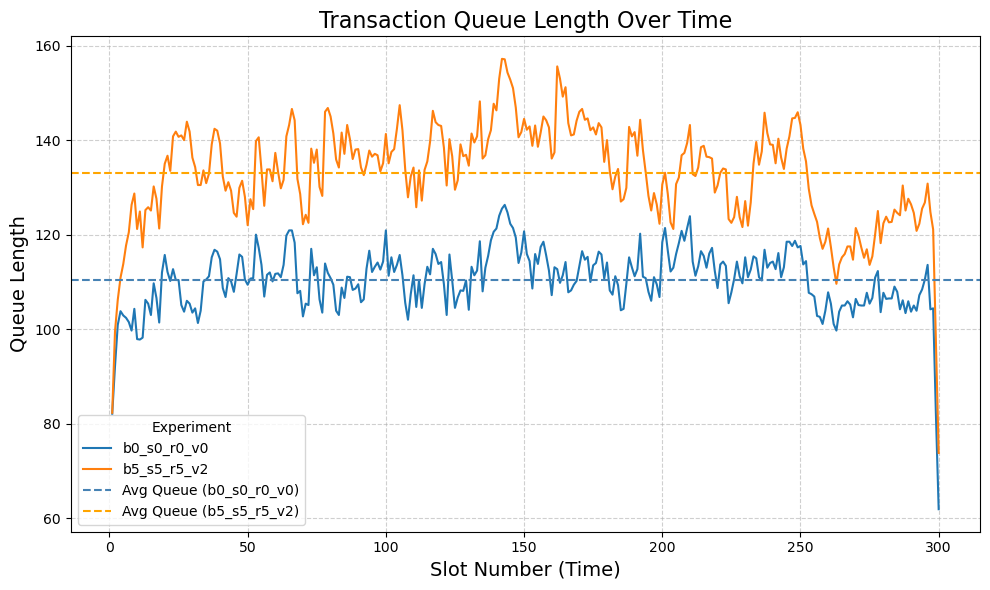


Overall average queue length (averaged across runs):
     experiment  queue_length
0  b0_s0_r0_v0       110.455
1  b5_s5_r5_v2       132.965


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Robust data loading and preprocessing function
def load_and_prepare(filepath, experiment_label, cutoff_time=3600, simulation_stop_time=3600):
    df = pd.read_csv(filepath)
    df = df[df['arrival_time'] <= cutoff_time].copy()
    df['experiment'] = experiment_label
    
    # Calculate proposal delay
    df['proposal_delay'] = df['proposed_time'] - df['arrival_time']
    df.loc[~df['is_proposed'], 'proposal_delay'] = simulation_stop_time - df.loc[~df['is_proposed'], 'arrival_time']
    
    df['sanctioned_type'] = df['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    return df

simulation_stop_time = 3600  # Defined simulation end time (although simulation was run until 3601.1 to ensure final slot transactions could be proposed, statistics should stop at 3600)

# Load two datasets
transactions1 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/transactions.csv", 
    'b0_s0_r0_v0'
)

transactions2 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/transactions.csv", 
    'b5_s5_r5_v2'
)

combined_transactions = pd.concat([transactions1, transactions2], ignore_index=True)

# ======= Statistics for number and ratio of proposed and unproposed transactions =======


# Total number of transactions generated per run
total_generated_tx = combined_transactions.groupby(['experiment', 'run_id'])['tx_id'].max().reset_index().rename(columns={'tx_id':'total_generated'})

# Number of proposed transactions per run
proposed_stats_run = combined_transactions[combined_transactions['is_proposed']].groupby(
    ['experiment', 'run_id', 'sanctioned_type']
)['tx_id'].count().reset_index(name='num_proposed')

# Total number of proposed transactions
total_proposed_per_run = proposed_stats_run.groupby(['experiment', 'run_id'])['num_proposed'].sum().reset_index(name='total_proposed')

# Number of unproposed transactions
unproposed_total_per_run = pd.merge(total_generated_tx, total_proposed_per_run, on=['experiment','run_id'])
unproposed_total_per_run['num_unproposed_total'] = unproposed_total_per_run['total_generated'] - unproposed_total_per_run['total_proposed']

# Allocate unproposed transactions by type based on proposal ratio
sanctioned_ratio = proposed_stats_run.pivot_table(index=['experiment','run_id'], columns='sanctioned_type', values='num_proposed', fill_value=0)
sanctioned_ratio = sanctioned_ratio.div(sanctioned_ratio.sum(axis=1), axis=0)

unproposed_by_type = unproposed_total_per_run[['experiment','run_id','num_unproposed_total']].set_index(['experiment','run_id']).join(sanctioned_ratio).reset_index()
for col in sanctioned_ratio.columns:
    unproposed_by_type[col] = (unproposed_by_type['num_unproposed_total'] * unproposed_by_type[col]).round().astype(int)

# Reformat unproposed transaction stats
unproposed_stats_run = unproposed_by_type.melt(
    id_vars=['experiment','run_id'], 
    value_vars=sanctioned_ratio.columns,
    var_name='sanctioned_type', 
    value_name='num_unproposed'
)

# Merge proposed and unproposed transaction stats to compute ratio
final_stats_run = pd.merge(
    proposed_stats_run, 
    unproposed_stats_run, 
    on=['experiment', 'run_id', 'sanctioned_type'], 
    how='left'
)

final_stats_run['total_transactions'] = final_stats_run['num_proposed'] + final_stats_run['num_unproposed']
final_stats_run['unproposed_ratio'] = final_stats_run['num_unproposed'] / final_stats_run['total_transactions']

# Aggregate across runs
final_avg_stats = final_stats_run.groupby(['experiment', 'sanctioned_type']).agg({
    'num_proposed': 'mean',
    'num_unproposed': 'mean',
    'unproposed_ratio': 'mean'
}).reset_index()

final_avg_stats['unproposed_ratio'] = (final_avg_stats['unproposed_ratio'] * 100).round(2).astype(str) + '%'

print("Transaction statistics (arrival_time ≤ 3600 seconds):\n", final_avg_stats)

# ======= Compute actual average delay W =======

# Average delay W per run
run_W_stats = combined_transactions.groupby(['experiment', 'run_id'])['proposal_delay'].mean().reset_index(name='W_run')

# Final W averaged across runs
final_W_actual = run_W_stats.groupby('experiment')['W_run'].mean().reset_index().rename(columns={'W_run':'W_actual'})
print("\nActual average delay W (arrival_time ≤ 3600 seconds):\n", final_W_actual)

# ======= Queue length statistics =======

slot_duration = 12
num_slots = int(simulation_stop_time // slot_duration)

queue_lengths = []

for experiment_label, exp_data in combined_transactions.groupby('experiment'):
    for run_id, run_data in exp_data.groupby('run_id'):
        for slot_no in range(1, num_slots + 1):
            t = slot_no * slot_duration
            arrivals = run_data[run_data['arrival_time'] < t].shape[0]
            proposals = run_data[(run_data['is_proposed']) & (run_data['proposed_time'] <= t + 1)].shape[0]
            queue_length = arrivals - proposals

            queue_lengths.append({
                'experiment': experiment_label,
                'run_id': run_id,
                'slot_no': slot_no,
                'queue_length': queue_length
            })

queue_lengths_df = pd.DataFrame(queue_lengths)

# Plot queue lengths over time
avg_queue_per_slot = queue_lengths_df.groupby(['experiment', 'slot_no'])['queue_length'].mean().reset_index()
plt.figure(figsize=(10,6))
for experiment_label, exp_data in avg_queue_per_slot.groupby('experiment'):
    plt.plot(exp_data['slot_no'], exp_data['queue_length'], label=experiment_label)

plt.xlabel("Slot Number (Time)", fontsize=14)
plt.ylabel("Queue Length", fontsize=14)
plt.title("Transaction Queue Length Over Time", fontsize=16)
plt.axhline(y=110.455, color='steelblue', linestyle='--', label='Avg Queue (b0_s0_r0_v0)')
plt.axhline(y=132.965, color='orange', linestyle='--', label='Avg Queue (b5_s5_r5_v2)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Experiment")
plt.tight_layout()
plt.show()

# Overall average queue length
avg_queue_length_per_run = queue_lengths_df.groupby(['experiment', 'run_id'])['queue_length'].mean().reset_index()
overall_avg_queue_length = avg_queue_length_per_run.groupby('experiment')['queue_length'].mean().reset_index()
print("\nOverall average queue length (averaged across runs):\n", overall_avg_queue_length)


In [12]:
import pandas as pd

# Known parameters
lambda_rate = 13  # Transaction arrival rate (transactions/sec)

# Organize data
data = {
    'experiment': ['b0_s0_r0_v0', 'b5_s5_r5_v2'],
    'tx_rate': [lambda_rate, lambda_rate],
    'W_actual': [15.484859, 17.214082],
    'W_adjust': [8.5, 10.5],
    'L_actual': [110.455, 132.965]
}

df = pd.DataFrame(data)

# Calculate theoretical queue length
df['L_theoretical'] = df['W_actual'] * df['tx_rate']
df['L_adjust'] = df['W_adjust'] * df['tx_rate']

# Calculate percentage differences
df['difference(%)'] = (abs(df['L_actual'] - df['L_theoretical']) / df['L_theoretical'] * 100)
df['difference_adjust(%)'] = (abs(df['L_actual'] - df['L_adjust']) / df['L_adjust'] * 100)

# Final column order
final_df = df[['experiment', 'tx_rate', 'W_actual', 'W_adjust', 'L_actual', 
               'L_theoretical', 'difference(%)', 'difference_adjust(%)']]


# Display final result
print(final_df)


    experiment  tx_rate   W_actual  W_adjust  L_actual  L_theoretical  \
0  b0_s0_r0_v0       13  15.484859       8.5   110.455     201.303167   
1  b5_s5_r5_v2       13  17.214082      10.5   132.965     223.783066   

   difference(%)  difference_adjust(%)  
0      45.130024              0.040724  
1      40.583082              2.589744  


In [13]:
import pandas as pd

# Load data function (includes all transactions, even unproposed ones)
def load_and_prepare_all(filepath, experiment_label, cutoff_time=3600):
    df = pd.read_csv(filepath)
    df = df[df['arrival_time'] <= cutoff_time].copy()
    df['experiment'] = experiment_label
    return df

# Load proposed transactions only (for computing service rate μ)
def load_and_prepare_proposed(filepath, experiment_label, cutoff_time=3600):
    df = pd.read_csv(filepath)
    df = df[(df['arrival_time'] <= cutoff_time) & (df['is_proposed'])].copy()
    df['experiment'] = experiment_label
    df['slot_no'] = ((df['proposed_time'] - 1) // 12).astype(int)
    return df

# Load full transaction data (for computing arrival rate λ)
transactions_all_1 = load_and_prepare_all(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/transactions.csv", 
    'b0_s0_r0_v0'
)
transactions_all_2 = load_and_prepare_all(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/transactions.csv", 
    'b5_s5_r5_v2'
)

combined_all_transactions = pd.concat([transactions_all_1, transactions_all_2], ignore_index=True)

# Count total arrived transactions per run and compute arrival rate λ
tx_arrival_counts = combined_all_transactions.groupby(['experiment', 'run_id']).size().reset_index(name='total_arrived')
tx_arrival_counts['lambda (tx/s)'] = tx_arrival_counts['total_arrived'] / 3600  

# Compute average arrival rate (across runs)
avg_lambda = tx_arrival_counts.groupby('experiment')['lambda (tx/s)'].mean().reset_index()

# Load proposed transactions (for computing service rate μ)
transactions_proposed_1 = load_and_prepare_proposed(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/transactions.csv", 
    'b0_s0_r0_v0'
)
transactions_proposed_2 = load_and_prepare_proposed(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/transactions.csv", 
    'b5_s5_r5_v2'
)

combined_transactions_proposed = pd.concat([transactions_proposed_1, transactions_proposed_2], ignore_index=True)

# Count proposed transactions per slot
tx_per_slot = combined_transactions_proposed.groupby(['experiment', 'run_id', 'slot_no']).size().reset_index(name='tx_count')

# Compute average service rate μ across runs
avg_tx_per_slot = tx_per_slot.groupby('experiment')['tx_count'].mean().reset_index()
avg_tx_per_slot['mu (tx/s)'] = avg_tx_per_slot['tx_count'] / 12

# Merge arrival rate and service rate, then compute ρ
queue_params = pd.merge(avg_lambda, avg_tx_per_slot[['experiment', 'mu (tx/s)']], on='experiment')

# Compute utilization rate ρ = λ / μ
queue_params['rho (λ/μ)'] = queue_params['lambda (tx/s)'] / queue_params['mu (tx/s)']

print("Empirical arrival rate (λ), service rate (μ), and utilization rate (ρ):\n")
print(queue_params)


Empirical arrival rate (λ), service rate (μ), and utilization rate (ρ):

    experiment  lambda (tx/s)  mu (tx/s)  rho (λ/μ)
0  b0_s0_r0_v0      12.988194  12.979653   1.000658
1  b5_s5_r5_v2      12.988194  12.980675   1.000579


#### Block-level analysis - Number/Ratio of blocks containing TC transactions (over time)
#### The proportion is calculated excluding empty blocks

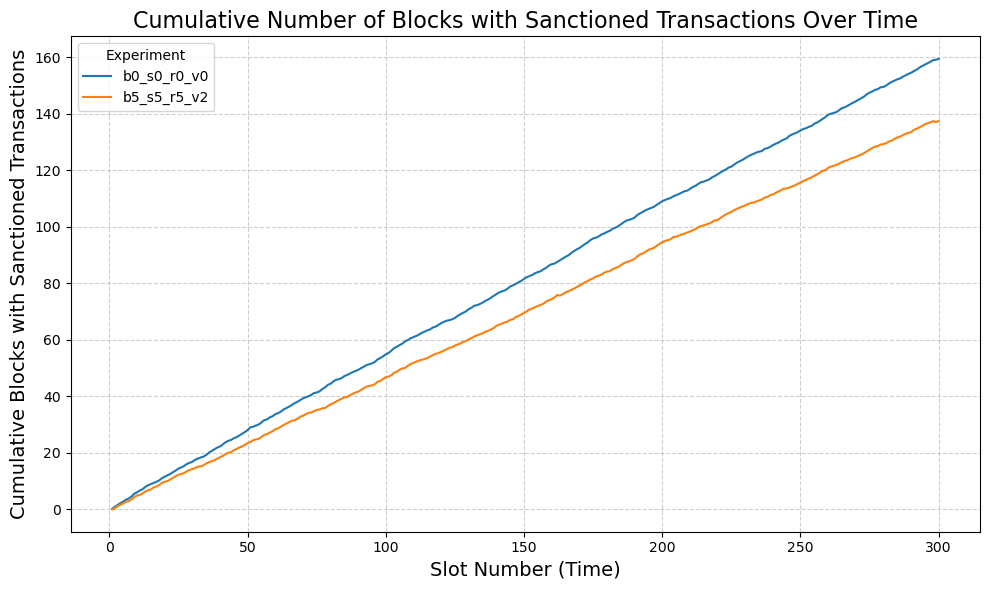

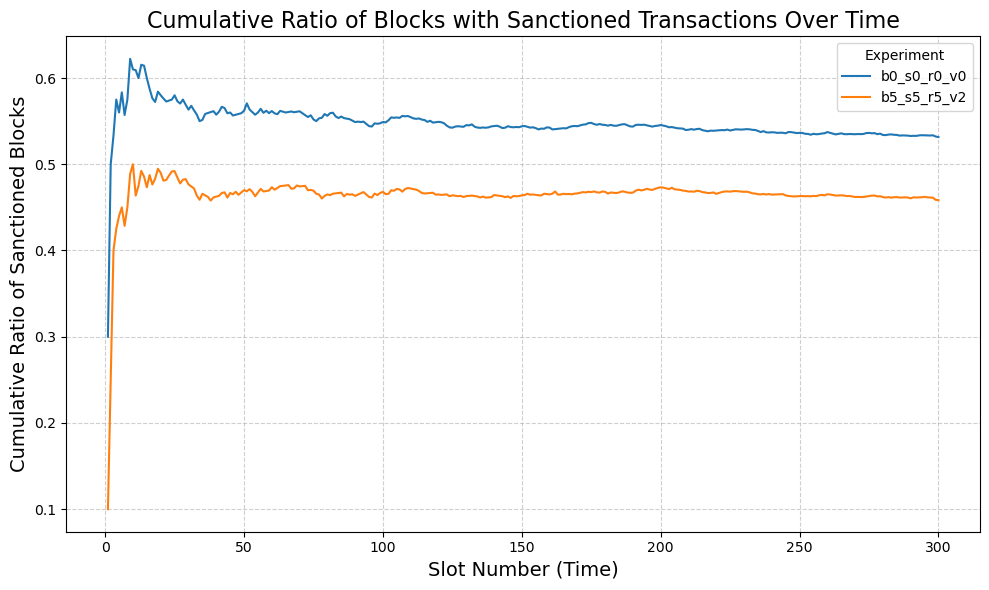

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load and process block data
def load_blocks(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    df['slot_no'] = df['slot_no'].astype(int)
    df['contains_sanctioned'] = df['num_sanctioned_tx'] > 0
    df['experiment'] = experiment_label
    return df

# Load block data from two experiments
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)

blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

combined_blocks = pd.concat([blocks1, blocks2], ignore_index=True)

# For each experiment, run_id, and slot_no, compute cumulative count of blocks containing sanctioned transactions
combined_blocks.sort_values(['experiment', 'run_id', 'slot_no'], inplace=True)
combined_blocks['cum_sanctioned_blocks'] = combined_blocks.groupby(['experiment', 'run_id'])['contains_sanctioned'].cumsum()
combined_blocks['cum_total_blocks'] = combined_blocks.groupby(['experiment', 'run_id']).cumcount() + 1

# Compute the average cumulative values across runs
avg_cum_blocks = combined_blocks.groupby(['experiment', 'slot_no']).agg({
    'cum_sanctioned_blocks': 'mean',
    'cum_total_blocks': 'mean'
}).reset_index()

# Compute the ratio of blocks containing sanctioned transactions
avg_cum_blocks['cum_sanctioned_ratio'] = avg_cum_blocks['cum_sanctioned_blocks'] / avg_cum_blocks['cum_total_blocks']

# Plot cumulative number of sanctioned blocks over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cum_blocks, x='slot_no', y='cum_sanctioned_blocks', hue='experiment')

plt.xlabel('Slot Number (Time)', fontsize=14)
plt.ylabel('Cumulative Blocks with Sanctioned Transactions', fontsize=14)
plt.title('Cumulative Number of Blocks with Sanctioned Transactions Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Experiment')
plt.tight_layout()
plt.show()

# Plot cumulative ratio of sanctioned blocks over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cum_blocks, x='slot_no', y='cum_sanctioned_ratio', hue='experiment')

plt.xlabel('Slot Number (Time)', fontsize=14)
plt.ylabel('Cumulative Ratio of Sanctioned Blocks', fontsize=14)
plt.title('Cumulative Ratio of Blocks with Sanctioned Transactions Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Experiment')
plt.tight_layout()
plt.show()


#### Ratio of blocks with/without TC transactions (over time)
#### The proportion is calculated including empty blocks

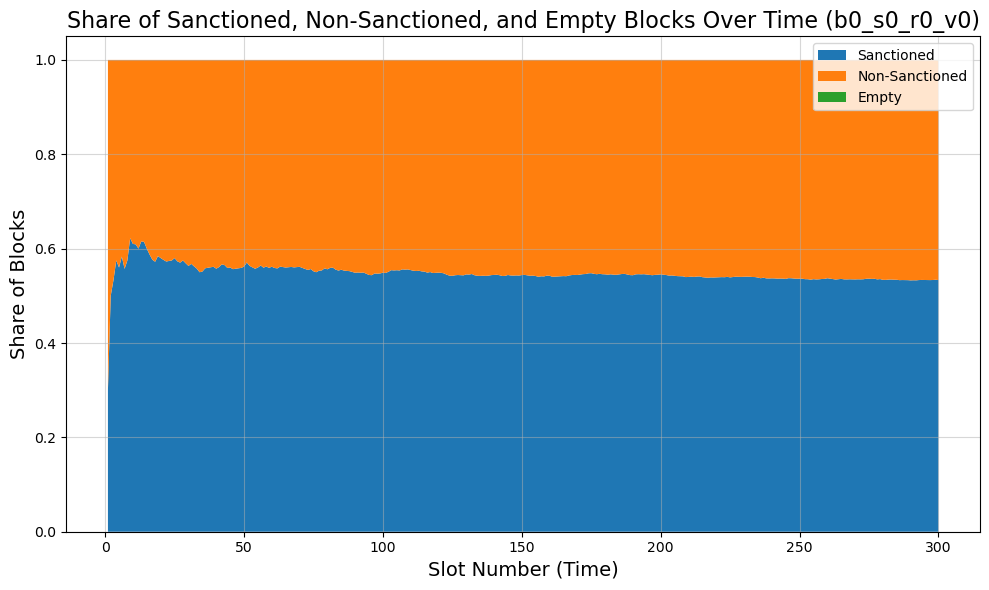

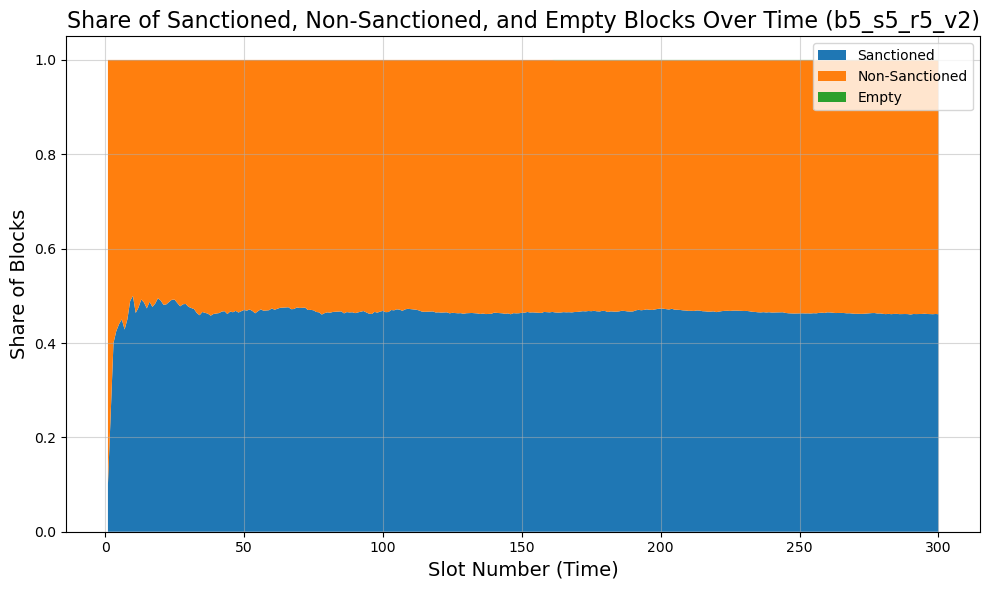

In [15]:

# Function to load and preprocess block data
def load_and_prepare_blocks(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[df['is_proposed']].copy()
    df['slot_no'] = df['slot_no'].astype(int)
    df['is_sanctioned'] = df['num_sanctioned_tx'] > 0
    df['is_empty'] = df['builder_id'] == 'PROPOSER'
    df['is_non_sanctioned'] = (df['num_sanctioned_tx'] == 0) & (df['num_transactions'] > 0)
    df['experiment'] = experiment_label
    return df

# Load block data for both experiments
blocks1 = load_and_prepare_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)
blocks2 = load_and_prepare_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)



# Plotting function for block share over time
def plot_block_share(df, experiment_label):
    df.sort_values(['run_id', 'slot_no'], inplace=True)
    df_grouped = df.groupby(['run_id', 'slot_no']).agg({
        'is_sanctioned': 'sum',
        'is_non_sanctioned': 'sum',
        'is_empty': 'sum'
    }).groupby('slot_no').mean().cumsum()

    df_grouped_ratio = df_grouped.div(df_grouped.sum(axis=1), axis=0)

    plt.figure(figsize=(10, 6))
    plt.stackplot(df_grouped_ratio.index,
                  df_grouped_ratio['is_sanctioned'],
                  df_grouped_ratio['is_non_sanctioned'],
                  df_grouped_ratio['is_empty'],
                  labels=['Sanctioned', 'Non-Sanctioned', 'Empty'])
                #   colors=['#d7191c', '#2c7bb6', '#cccccc'])

    plt.xlabel('Slot Number (Time)', fontsize=14)
    plt.ylabel('Share of Blocks', fontsize=14)
    plt.title(f'Share of Sanctioned, Non-Sanctioned, and Empty Blocks Over Time ({experiment_label})', fontsize=16)
    plt.legend(loc='upper right')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot block share for each experiment
plot_block_share(blocks1, 'b0_s0_r0_v0')
plot_block_share(blocks2, 'b5_s5_r5_v2')


#### Variation in the Number of TC Transactions in Proposed Blocks

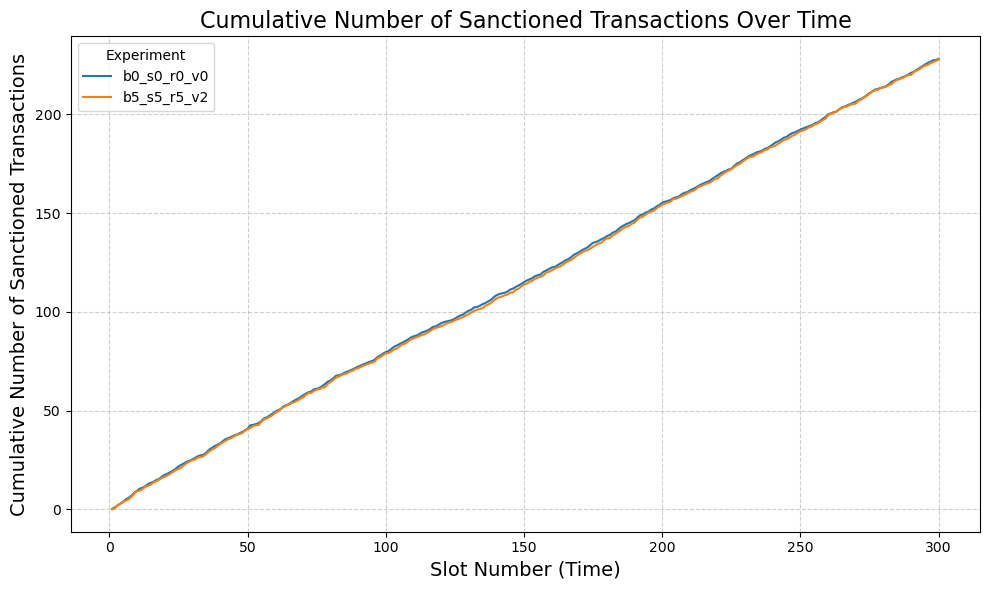

In [16]:

# Function to load and process block data
def load_blocks(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    df['slot_no'] = df['slot_no'].astype(int)
    df['num_sanctioned_tx'] = df['num_sanctioned_tx'].fillna(0).astype(int)
    df['experiment'] = experiment_label
    return df

# Load block data from two experiments
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)

blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

# Combine datasets
combined_blocks = pd.concat([blocks1, blocks2], ignore_index=True)

# For each experiment, run_id, and slot_no, calculate cumulative number of TC (sanctioned) transactions
combined_blocks.sort_values(['experiment', 'run_id', 'slot_no'], inplace=True)
combined_blocks['cum_sanctioned_tx'] = combined_blocks.groupby(['experiment', 'run_id'])['num_sanctioned_tx'].cumsum()

# Compute the average cumulative value across different runs
avg_cum_tx = combined_blocks.groupby(['experiment', 'slot_no'])['cum_sanctioned_tx'].mean().reset_index()

# Plot the cumulative number of TC (sanctioned) transactions over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cum_tx, x='slot_no', y='cum_sanctioned_tx', hue='experiment')

plt.xlabel('Slot Number (Time)', fontsize=14)
plt.ylabel('Cumulative Number of Sanctioned Transactions', fontsize=14)
plt.title('Cumulative Number of Sanctioned Transactions Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Experiment')
plt.tight_layout()
plt.show()


#### Block-Level Analysis – Number/Proportion of Blocks Containing TC Transactions (Excluding Empty Blocks)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset 1
file_path1 = "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv"
blocks1 = pd.read_csv(file_path1)
blocks1 = blocks1[(blocks1['is_proposed']) & (blocks1['builder_id'] != 'PROPOSER')].copy()
blocks1['builder_id'] = blocks1['builder_id'].astype(int)
blocks1['selected_relay_id'] = blocks1['selected_relay_id'].astype('Int64')
blocks1['proposer_validator_id'] = blocks1['proposer_validator_id'].astype('Int64')
blocks1['contains_sanctioned'] = blocks1['num_sanctioned_tx'] > 0
blocks1['experiment'] = 'b0_s0_r0_v0'


# Load Dataset 2
file_path2 = "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv"
blocks2 = pd.read_csv(file_path2)
blocks2 = blocks2[(blocks2['is_proposed']) & (blocks2['builder_id'] != 'PROPOSER')].copy()
blocks2['builder_id'] = blocks2['builder_id'].astype(int)
blocks2['selected_relay_id'] = blocks2['selected_relay_id'].astype('Int64')
blocks2['proposer_validator_id'] = blocks2['proposer_validator_id'].astype('Int64')
blocks2['contains_sanctioned'] = blocks2['num_sanctioned_tx'] > 0
blocks2['experiment'] = 'b5_s5_r5_v2'



# Merge the two datasets
combined_blocks = pd.concat([blocks1, blocks2], ignore_index=True)

# For each builder in each run, calculate statistics on block content
def get_builder_stats(exp_blocks, total_runs):
    builder_run_stats = exp_blocks.groupby(['run_id', 'builder_id'])['contains_sanctioned'].agg([
        ('blocks_with_sanctioned_transactions', 'sum'),
        ('blocks_without_sanctioned_transactions', lambda x: (~x).sum()),
        ('total_blocks', 'count')
    ]).reset_index()

    all_builder_ids = exp_blocks['builder_id'].unique()
    all_run_ids = exp_blocks['run_id'].unique()
    full_index = pd.MultiIndex.from_product([all_run_ids, all_builder_ids], names=['run_id', 'builder_id'])
    builder_run_stats = builder_run_stats.set_index(['run_id', 'builder_id']).reindex(full_index, fill_value=0).reset_index()

    mean_builder_stats = builder_run_stats.groupby('builder_id')[['blocks_with_sanctioned_transactions', 'blocks_without_sanctioned_transactions', 'total_blocks']].sum() / total_runs
    return mean_builder_stats.reset_index()


# Generate statistics for each experiment
stats1 = get_builder_stats(blocks1, blocks1['run_id'].nunique())
stats1['experiment'] = 'b0_s0_r0_v0'
stats2 = get_builder_stats(blocks2, blocks2['run_id'].nunique())
stats2['experiment'] = 'b5_s5_r5_v2'

# Combine statistics for comparison
combined_stats = pd.concat([stats1, stats2])

for exp, data in [('b0_s0_r0_v0', blocks1), ('b5_s5_r5_v2', blocks2)]:
    run_summary = data.groupby('run_id').agg(
        total_blocks_with_sanctioned=('contains_sanctioned', 'sum'),
        total_blocks=('block_id', 'count')
    ).reset_index()

    run_summary['blocks_without_sanctioned'] = run_summary['total_blocks'] - run_summary['total_blocks_with_sanctioned']
    run_summary['ratio_with_sanctioned'] = run_summary['total_blocks_with_sanctioned'] / run_summary['total_blocks']
    run_summary['ratio_without_sanctioned'] = run_summary['blocks_without_sanctioned'] / run_summary['total_blocks']

    avg_blocks_with_sanctioned = run_summary['total_blocks_with_sanctioned'].mean()
    avg_blocks_without_sanctioned = run_summary['blocks_without_sanctioned'].mean()
    avg_total_blocks = run_summary['total_blocks'].mean()
    avg_ratio_with_sanctioned = run_summary['ratio_with_sanctioned'].mean()
    avg_ratio_without_sanctioned = run_summary['ratio_without_sanctioned'].mean()

    print(f"\nExperiment: {exp}")
    print(f"Average number of blocks containing sanctioned_type=1 transactions: {avg_blocks_with_sanctioned:.6f}")
    print(f"Average number of blocks not containing sanctioned_type=1 transactions (excluding empty blocks): {avg_blocks_without_sanctioned:.6f}")
    print(f"Proportion of blocks with sanctioned_type=1 transactions among all proposed non-empty blocks: {avg_ratio_with_sanctioned:.2%}")
    print(f"Proportion of blocks without sanctioned_type=1 transactions among all proposed non-empty blocks: {avg_ratio_without_sanctioned:.2%}")




Experiment: b0_s0_r0_v0
Average number of blocks containing sanctioned_type=1 transactions: 160.000000
Average number of blocks not containing sanctioned_type=1 transactions (excluding empty blocks): 139.800000
Proportion of blocks with sanctioned_type=1 transactions among all proposed non-empty blocks: 53.37%
Proportion of blocks without sanctioned_type=1 transactions among all proposed non-empty blocks: 46.63%

Experiment: b5_s5_r5_v2
Average number of blocks containing sanctioned_type=1 transactions: 138.300000
Average number of blocks not containing sanctioned_type=1 transactions (excluding empty blocks): 161.400000
Proportion of blocks with sanctioned_type=1 transactions among all proposed non-empty blocks: 46.15%
Proportion of blocks without sanctioned_type=1 transactions among all proposed non-empty blocks: 53.85%


Unique number of builder nodes per strategy in each experiment:
 experiment   builder_policy
b0_s0_r0_v0  non               20
b5_s5_r5_v2  non               10
             strict             5
             weak               5
dtype: int64

Builder strategy distribution in experiment b0_s0_r0_v0:
builder_id  builder_policy
0           non               1
1           non               1
8           non               1
7           non               1
6           non               1
5           non               1
4           non               1
3           non               1
2           non               1
19          non               1
18          non               1
17          non               1
16          non               1
15          non               1
14          non               1
13          non               1
12          non               1
11          non               1
10          non               1
9           non               1
Name: count, dtype: int64

Number

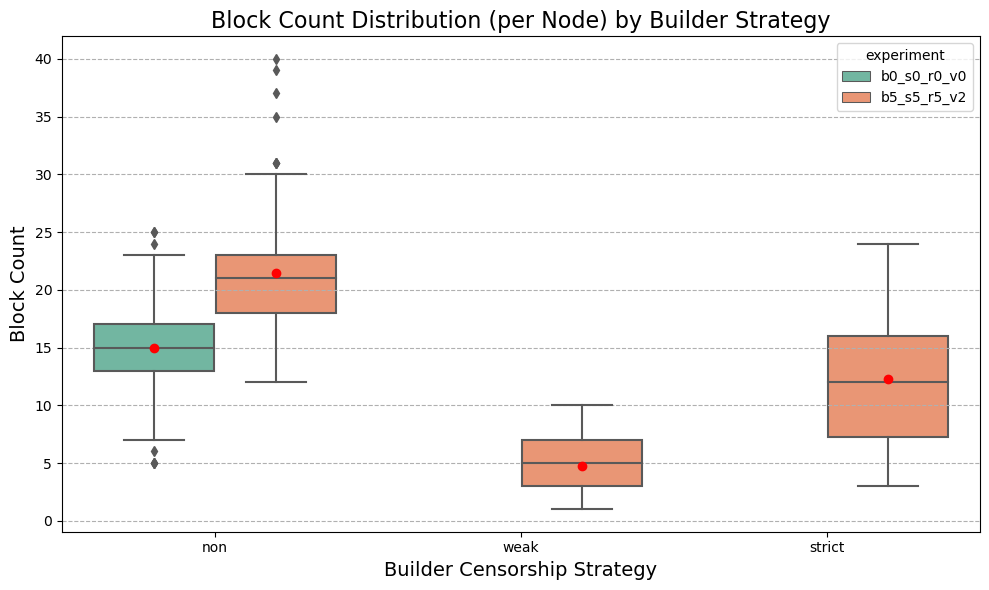

experiment   builder_policy
b0_s0_r0_v0  non               14.99000
b5_s5_r5_v2  non               21.49000
             strict            12.28000
             weak               4.77551
Name: block_count, dtype: float64


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Explicitly specify builder_id type as string to avoid duplicate counting due to type mismatch
def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    # 统一所有节点ID的数据类型为字符串并去除空格
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df


# Load data from two experiments
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)

blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

# Count number of blocks proposed by each builder in each run
def node_level_block_counts(df):
    return df.groupby(['run_id', 'builder_id']).size().reset_index(name='block_count')

# Experiment 1 builder statistics (with strategy labels)
builder_counts1 = node_level_block_counts(blocks1)
policy_map1 = blocks1[['builder_id', 'builder_policy']].drop_duplicates()
builder_counts1 = pd.merge(builder_counts1, policy_map1, on='builder_id', how='left')
builder_counts1['experiment'] = 'b0_s0_r0_v0'

# Experiment 2 builder statistics (with strategy labels)
builder_counts2 = node_level_block_counts(blocks2)
policy_map2 = blocks2[['builder_id', 'builder_policy']].drop_duplicates()
builder_counts2 = pd.merge(builder_counts2, policy_map2, on='builder_id', how='left')
builder_counts2['experiment'] = 'b5_s5_r5_v2'


# Combine both for visualization
builder_node_counts = pd.concat([builder_counts1, builder_counts2], ignore_index=True)

# Check unique number of builders per strategy in each experiment
builder_unique_counts = builder_node_counts[['experiment', 'builder_id', 'builder_policy']].drop_duplicates()
builder_unique_summary = builder_unique_counts.groupby(['experiment', 'builder_policy']).size()
print("Unique number of builder nodes per strategy in each experiment:\n", builder_unique_summary)

# Validation outputs for experiment 1
print("\nBuilder strategy distribution in experiment b0_s0_r0_v0:")
print(blocks1[['builder_id', 'builder_policy']].drop_duplicates().value_counts())

print("\nNumber of blocks proposed per run in b0_s0_r0_v0:")
print(blocks1.groupby('run_id').size())

print("\nAverage number of blocks per builder in b0_s0_r0_v0:")
print(builder_counts1.groupby('builder_id')['block_count'].mean())

# Strategy display order
policy_order = ['non', 'weak', 'strict']

# Plot: builder strategy vs block count per node
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=builder_node_counts,
    x='builder_policy',
    y='block_count',
    order=policy_order,
    hue='experiment',
    palette='Set2',
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"red"}
)
plt.title('Block Count Distribution (per Node) by Builder Strategy', fontsize=16)
plt.ylabel('Block Count', fontsize=14)
plt.xlabel('Builder Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Print mean block count per strategy per experiment
print(builder_node_counts.groupby(['experiment', 'builder_policy'])['block_count'].mean())


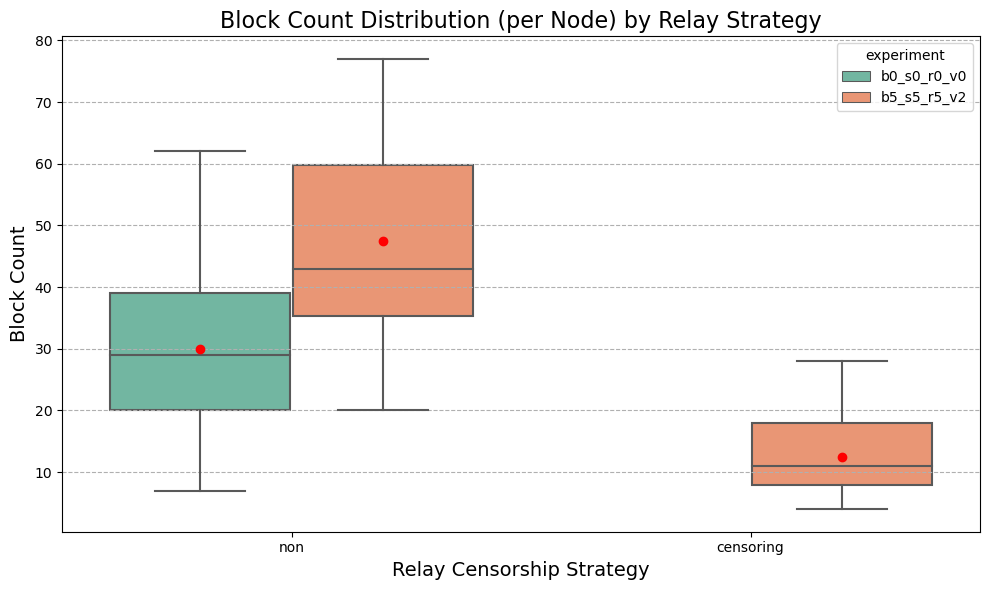

experiment   selected_relay_policy
b0_s0_r0_v0  non                      29.98
b5_s5_r5_v2  censoring                12.44
             non                      47.50
Name: block_count, dtype: float64


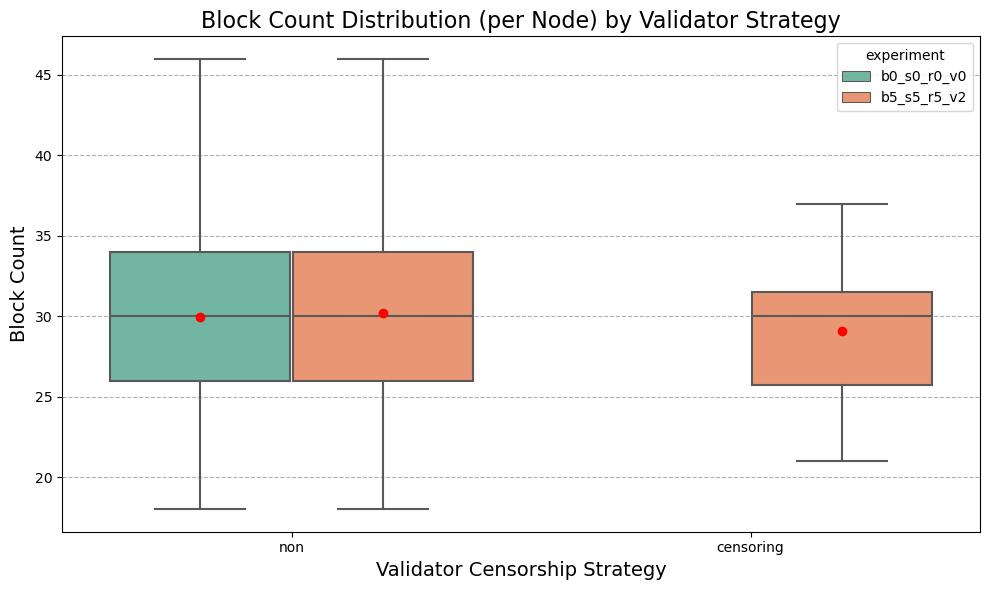

experiment   proposer_validator_policy
b0_s0_r0_v0  non                          29.9800
b5_s5_r5_v2  censoring                    29.1000
             non                          30.1875
Name: block_count, dtype: float64


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Force ID fields to be string to ensure consistency
def load_blocks(filepath, tag):
    df = pd.read_csv(filepath, dtype={
        'selected_relay_id': str,
        'proposer_validator_id': str,
        'builder_id': str
    })
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    df['experiment'] = tag
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    df['proposer_validator_policy'] = df['proposer_validator_is_censoring'].map({False: 'non', True: 'censoring'})
    return df


# Load two experiments
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)

blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

# Generic block count function by node
def node_level_block_counts(df, node_field, policy_field):
    node_counts = df.groupby(['run_id', node_field]).size().reset_index(name='block_count')
    policy_mapping = df[[node_field, policy_field]].drop_duplicates()
    return pd.merge(node_counts, policy_mapping, on=node_field, how='left')

# ========== Relay statistics ==========
relay_counts1 = node_level_block_counts(blocks1, 'selected_relay_id', 'selected_relay_policy')
relay_counts1['experiment'] = 'b0_s0_r0_v0'

relay_counts2 = node_level_block_counts(blocks2, 'selected_relay_id', 'selected_relay_policy')
relay_counts2['experiment'] = 'b5_s5_r5_v2'

relay_node_counts = pd.concat([relay_counts1, relay_counts2], ignore_index=True)
relay_policy_order = ['non', 'censoring']

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=relay_node_counts,
    x='selected_relay_policy',
    y='block_count',
    order=relay_policy_order,
    hue='experiment',
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Block Count Distribution (per Node) by Relay Strategy', fontsize=16)
plt.ylabel('Block Count', fontsize=14)
plt.xlabel('Relay Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(relay_node_counts.groupby(['experiment', 'selected_relay_policy'])['block_count'].mean())

# ========== Validator statistics ==========
validator_counts1 = node_level_block_counts(blocks1, 'proposer_validator_id', 'proposer_validator_policy')
validator_counts1['experiment'] = 'b0_s0_r0_v0'

validator_counts2 = node_level_block_counts(blocks2, 'proposer_validator_id', 'proposer_validator_policy')
validator_counts2['experiment'] = 'b5_s5_r5_v2'

validator_node_counts = pd.concat([validator_counts1, validator_counts2], ignore_index=True)
validator_policy_order = ['non', 'censoring']

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=validator_node_counts,
    x='proposer_validator_policy',  
    y='block_count',
    order=validator_policy_order,
    hue='experiment',
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Block Count Distribution (per Node) by Validator Strategy', fontsize=16)
plt.ylabel('Block Count', fontsize=14)
plt.xlabel('Validator Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(validator_node_counts.groupby(['experiment', 'proposer_validator_policy'])['block_count'].mean())


#### Block Value

Average total block value per run (ETH):
    experiment  total_priority_fee
0  b0_s0_r0_v0           11.909496
1  b5_s5_r5_v2           11.907747


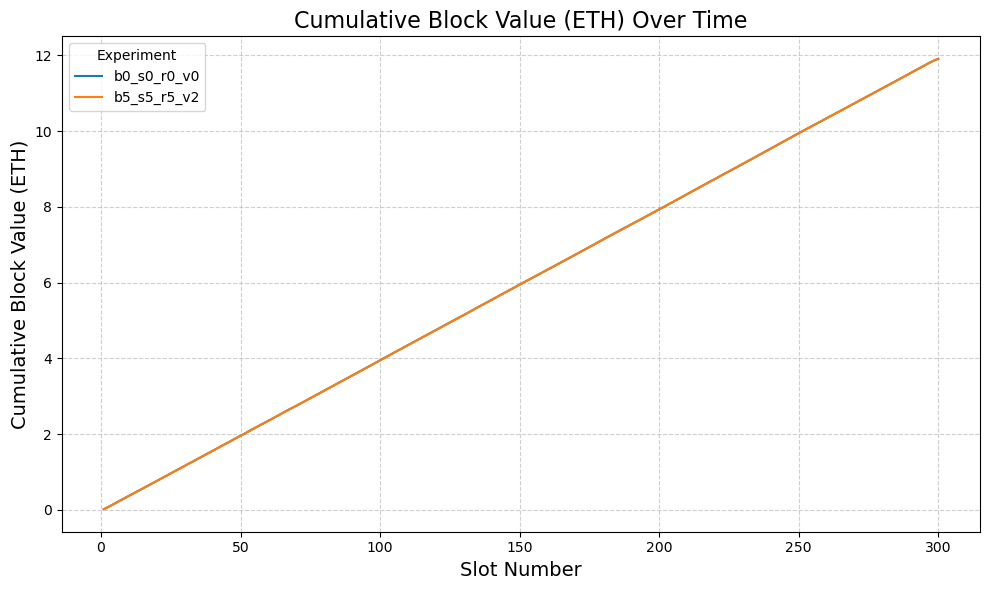

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess the blocks.csv data
def load_blocks(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[df['is_proposed']].copy()     # All proposed blocks (including empty blocks)
    df['slot_no'] = df['slot_no'].astype(int)
    df['experiment'] = experiment_label
    # Standardize builder_id, relay_id, and validator_id as string type and strip whitespace
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    return df


# Load block data from two experiments
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)

blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

# Merge the two datasets
combined_blocks = pd.concat([blocks1, blocks2], ignore_index=True)

# Calculate and print the total value of all proposed blocks (in ETH) for both experiments
total_values_eth = combined_blocks.groupby(['experiment', 'run_id'])['total_priority_fee'].sum().div(1e9).groupby('experiment').mean().reset_index()
print("Average total block value per run (ETH):")
print(total_values_eth)

# Compute cumulative value per run_id and slot_no, and convert to ETH
combined_blocks.sort_values(['experiment', 'run_id', 'slot_no'], inplace=True)
combined_blocks['cum_priority_fee_eth'] = combined_blocks.groupby(['experiment', 'run_id'])['total_priority_fee'].cumsum() / 1e9

# For each experiment and slot, compute the average cumulative value across runs (in ETH)
avg_cum_values = combined_blocks.groupby(['experiment', 'slot_no'])['cum_priority_fee_eth'].mean().reset_index()

# Plot the trend of cumulative block value over slot_no (in ETH)
plt.figure(figsize=(10, 6))
for experiment_label, group in avg_cum_values.groupby('experiment'):
    plt.plot(group['slot_no'], group['cum_priority_fee_eth'], label=experiment_label)

plt.xlabel('Slot Number', fontsize=14)
plt.ylabel('Cumulative Block Value (ETH)', fontsize=14)
plt.title('Cumulative Block Value (ETH) Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Experiment')
plt.tight_layout()
plt.show()


Average total block value per run (ETH):
    experiment  contains_sanctioned  total_priority_fee
0  b0_s0_r0_v0                False            5.555978
1  b0_s0_r0_v0                 True            6.353517
2  b5_s5_r5_v2                False            6.167530
3  b5_s5_r5_v2                 True            5.740218
Corrected average total block value per run (ETH):
    experiment  contains_sanctioned  total_priority_fee
0  b0_s0_r0_v0                False            5.555978
1  b0_s0_r0_v0                 True            6.353517
2  b5_s5_r5_v2                False            6.167530
3  b5_s5_r5_v2                 True            5.740218


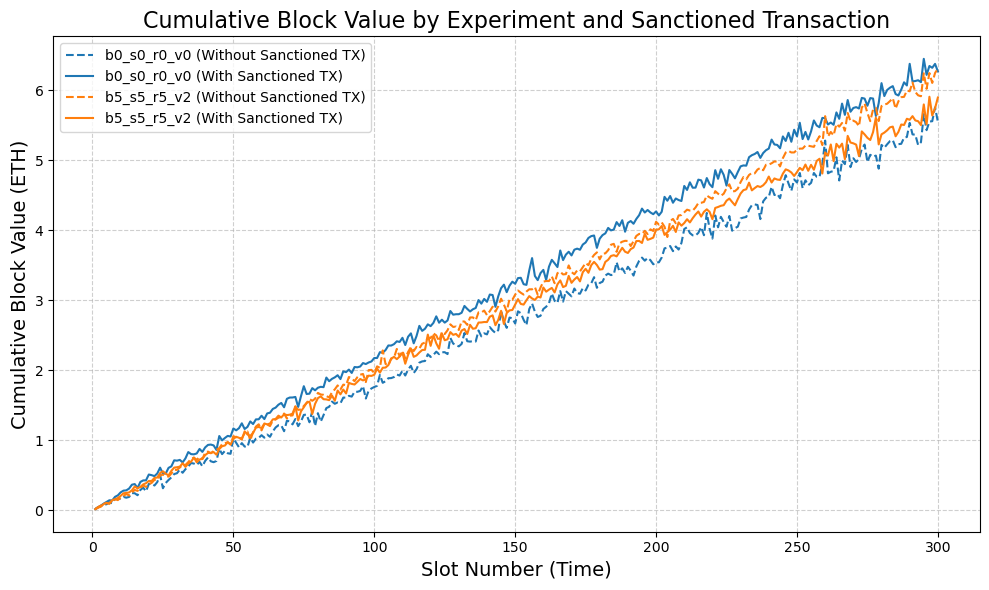

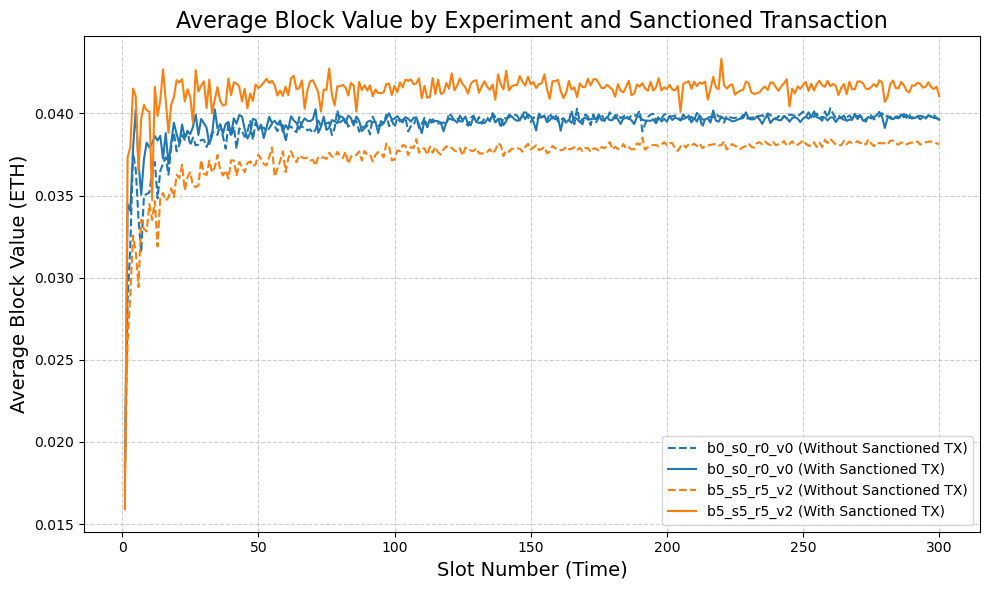

Average per-block value per run (ETH)
    experiment  contains_sanctioned  total_priority_fee
0  b0_s0_r0_v0                False            0.039746
1  b0_s0_r0_v0                 True            0.039715
2  b5_s5_r5_v2                False            0.038214
3  b5_s5_r5_v2                 True            0.041517
Corrected average per-block value per run (ETH)
    experiment  contains_sanctioned  avg_priority_fee_per_block
0  b0_s0_r0_v0                False                    0.039746
1  b0_s0_r0_v0                 True                    0.039715
2  b5_s5_r5_v2                False                    0.038214
3  b5_s5_r5_v2                 True                    0.041517


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess blocks.csv data
def load_blocks(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    df['slot_no'] = df['slot_no'].astype(int)
    df['experiment'] = experiment_label
    df['contains_sanctioned'] = df['num_sanctioned_tx'] > 0
    # Standardize builder_id, relay_id, and validator_id as string type and strip whitespace
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    return df

# Load block data from two experiments
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)

blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

# Merge the two datasets
combined_blocks = pd.concat([blocks1, blocks2], ignore_index=True)

# First average within each run, then average across runs
# Compute and print total block value (converted to ETH) for blocks with/without TC transactions in each experiment
total_values = combined_blocks.groupby(['experiment', 'contains_sanctioned', 'run_id'])['total_priority_fee'].sum().div(1e9).groupby(['experiment', 'contains_sanctioned']).mean().reset_index()
print("Average total block value per run (ETH):")
print(total_values)

total_values_corrected = (
    combined_blocks.groupby(['experiment', 'contains_sanctioned', 'run_id'])
    .agg(total_priority_fee=('total_priority_fee', 'sum'))
    .groupby(['experiment', 'contains_sanctioned'])['total_priority_fee']
    .mean()
    .div(1e9)
    .reset_index()
)

print("Corrected average total block value per run (ETH):")
print(total_values_corrected)

# Compute cumulative value per run_id and slot_no for blocks with/without TC transactions (converted to ETH)
combined_blocks.sort_values(['experiment', 'run_id', 'slot_no'], inplace=True)
combined_blocks['cum_priority_fee_eth'] = combined_blocks.groupby(['experiment', 'run_id', 'contains_sanctioned'])['total_priority_fee'].cumsum() / 1e9
combined_blocks['cum_block_count'] = combined_blocks.groupby(['experiment', 'run_id', 'contains_sanctioned']).cumcount() + 1
combined_blocks['avg_priority_fee_per_block_eth'] = combined_blocks['cum_priority_fee_eth'] / combined_blocks['cum_block_count']

# For each experiment and slot, compute average cumulative and per-block value across runs (ETH)
avg_cum_values = combined_blocks.groupby(['experiment', 'slot_no', 'contains_sanctioned']).agg({
    'cum_priority_fee_eth': 'mean',
    'avg_priority_fee_per_block_eth': 'mean'
}).reset_index()

# Labels
contains_label = {True: 'With Sanctioned TX', False: 'Without Sanctioned TX'}
color_map = {'b0_s0_r0_v0': "C0", 'b5_s5_r5_v2': "C1"}


# 1. Cumulative block value chart (ETH)
plt.figure(figsize=(10, 6))
for (experiment_label, contains), group in avg_cum_values.groupby(['experiment', 'contains_sanctioned']):
    plt.plot(
        group['slot_no'],
        group['cum_priority_fee_eth'],
        label=f"{experiment_label} ({contains_label[contains]})",
        color=color_map[experiment_label],
        linestyle='-' if contains else '--'
    )

plt.title('Cumulative Block Value by Experiment and Sanctioned Transaction', fontsize=16)
plt.xlabel('Slot Number (Time)', fontsize=14)
plt.ylabel('Cumulative Block Value (ETH)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Average block value chart (ETH)
plt.figure(figsize=(10, 6))
for (experiment_label, contains), group in avg_cum_values.groupby(['experiment', 'contains_sanctioned']):
    plt.plot(
        group['slot_no'],
        group['avg_priority_fee_per_block_eth'],
        label=f"{experiment_label} ({contains_label[contains]})",
        color=color_map[experiment_label],
        linestyle='-' if contains else '--'
    )

plt.title('Average Block Value by Experiment and Sanctioned Transaction', fontsize=16)
plt.xlabel('Slot Number (Time)', fontsize=14)
plt.ylabel('Average Block Value (ETH)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# First average within runs, then average across runs
# Print average block value per run
avg_block_values_per_run = combined_blocks.groupby(['experiment', 'contains_sanctioned', 'run_id'])['total_priority_fee'].mean().div(1e9).groupby(['experiment', 'contains_sanctioned']).mean()
print("Average per-block value per run (ETH)")
print(avg_block_values_per_run.reset_index())

# Correct: divide cumulative value per run by total block count, then average across runs
correct_avg_value_end_of_run = (
    combined_blocks.groupby(['experiment', 'contains_sanctioned', 'run_id'])
    .agg(total_priority_fee=('total_priority_fee', 'sum'), total_blocks=('total_priority_fee', 'count'))
    .assign(avg_priority_fee_per_block=lambda x: x['total_priority_fee'] / x['total_blocks'])
    .groupby(['experiment', 'contains_sanctioned'])['avg_priority_fee_per_block']
    .mean()
    .div(1e9)
    .reset_index()
)

print("Corrected average per-block value per run (ETH)")
print(correct_avg_value_end_of_run)


#### Visualization based on the censorship strategy of the builder, relay, and validator
#### Only final aggregate statistics are required; no need to plot time-series trends.

In [30]:
import pandas as pd

# Then average the sum across runs to get the overall average block value per strategy.
# For each run, sum the total block value proposed by all nodes under each strategy (not per-block average). Then average across runs.


def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    # Standardize all node ID fields to string type and remove any whitespace
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

# Load data from censorship experiment
blocks_censor = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv"
)

# Aggregate total block value per builder censorship strategy (average over runs)
builder_policy_stats = blocks_censor.groupby(['builder_policy', 'run_id'])['total_priority_fee'].sum().groupby('builder_policy').mean().reset_index()
builder_policy_stats['total_priority_fee_ETH'] = builder_policy_stats['total_priority_fee'] * 1e-9

print("Total block value (per strategy) by builder censorship strategy:")
print(builder_policy_stats)

# Aggregate total block value per relay censorship strategy (average over runs)
relay_policy_stats = blocks_censor.groupby(['selected_relay_policy', 'run_id'])['total_priority_fee'].sum().groupby('selected_relay_policy').mean().reset_index()
relay_policy_stats['total_priority_fee_ETH'] = relay_policy_stats['total_priority_fee'] * 1e-9

print("\nTotal block value (per strategy) by relay censorship strategy:")
print(relay_policy_stats)

# Aggregate total block value per validator censorship status (average over runs)
validator_policy_stats = blocks_censor.groupby(['proposer_validator_is_censoring', 'run_id'])['total_priority_fee'].sum().groupby('proposer_validator_is_censoring').mean().reset_index()
validator_policy_stats['total_priority_fee_ETH'] = validator_policy_stats['total_priority_fee'] * 1e-9
validator_policy_stats['proposer_validator_is_censoring'] = validator_policy_stats['proposer_validator_is_censoring'].map({True: 'Censoring', False: 'Non-censoring'})

print("\nTotal block value (per strategy) by validator censorship strategy:")
print(validator_policy_stats)


Total block value (per strategy) by builder censorship strategy:
  builder_policy  total_priority_fee  total_priority_fee_ETH
0            non        8.784005e+09                8.784005
1         strict        2.185543e+09                2.185543
2           weak        9.381987e+08                0.938199

Total block value (per strategy) by relay censorship strategy:
  selected_relay_policy  total_priority_fee  total_priority_fee_ETH
0             censoring        2.118878e+09                2.118878
1                   non        9.788869e+09                9.788869

Total block value (per strategy) by validator censorship strategy:
  proposer_validator_is_censoring  total_priority_fee  total_priority_fee_ETH
0                   Non-censoring        9.938868e+09                9.938868
1                       Censoring        1.968879e+09                1.968879


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    # Standardize all node ID fields to string type and remove whitespace
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

blocks_censor = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv"
)

# Compute the mean block value under each strategy per run (ignoring node-level differences)
def calculate_policy_level_mean(df, policy_field):
    policy_mean = df.groupby(['run_id', policy_field])['total_priority_fee'].mean().reset_index()
    return policy_mean

# Compute the standard deviation of block values under each strategy per run
def calculate_policy_level_std(df, policy_field):
    policy_std = df.groupby(['run_id', policy_field])['total_priority_fee'].std().reset_index()
    return policy_std

# Compute builder strategy statistics
builder_policy_values = calculate_policy_level_mean(blocks_censor, 'builder_policy')
builder_policy_std = calculate_policy_level_std(blocks_censor, 'builder_policy')

# Compute relay strategy statistics
relay_policy_values = calculate_policy_level_mean(blocks_censor, 'selected_relay_policy')
relay_policy_std = calculate_policy_level_std(blocks_censor, 'selected_relay_policy')

# Compute validator strategy statistics
blocks_censor['proposer_validator_is_censoring'] = blocks_censor['proposer_validator_is_censoring'].map({True: 'censoring', False: 'non'})
validator_policy_values = calculate_policy_level_mean(blocks_censor, 'proposer_validator_is_censoring')
validator_policy_std = calculate_policy_level_std(blocks_censor, 'proposer_validator_is_censoring')

# Compute the average of run-level means and standard deviations across all runs
def aggregate_across_runs(mean_stats, std_stats, policy_field):
    mean_df = mean_stats.groupby(policy_field)['total_priority_fee'].mean().reset_index(name='mean')
    std_df = std_stats.groupby(policy_field)['total_priority_fee'].mean().reset_index(name='mean_std')
    final_stats = pd.merge(mean_df, std_df, on=policy_field)
    return final_stats

builder_final_stats = aggregate_across_runs(builder_policy_values, builder_policy_std, 'builder_policy')
relay_final_stats = aggregate_across_runs(relay_policy_values, relay_policy_std, 'selected_relay_policy')
validator_final_stats = aggregate_across_runs(validator_policy_values, validator_policy_std, 'proposer_validator_is_censoring')

# Convert units to ETH
for df in [builder_final_stats, relay_final_stats, validator_final_stats]:
    df[['mean', 'mean_std']] *= 1e-9

# 打印结果
print("Cross-run mean block value (per block) and mean intra-run standard deviation by builder strategy (ETH):")
print(builder_final_stats)

print("\nCross-run mean block value (per block) and mean intra-run standard deviation by relay strategy (ETH):")
print(relay_final_stats)

print("\nCross-run mean block value (per block) and mean intra-run standard deviation by validator strategy (ETH):")
print(validator_final_stats)

Cross-run mean block value (per block) and mean intra-run standard deviation by builder strategy (ETH):
  builder_policy      mean  mean_std
0            non  0.039725  0.003715

Cross-run mean block value (per block) and mean intra-run standard deviation by relay strategy (ETH):
  selected_relay_policy      mean  mean_std
0                   non  0.039725  0.003715

Cross-run mean block value (per block) and mean intra-run standard deviation by validator strategy (ETH):
  proposer_validator_is_censoring      mean  mean_std
0                             non  0.039725  0.003715


Cross-run mean and intra-run std (averaged across runs) of block value (per block) by Builder strategy (ETH):
  builder_policy      mean  mean_std
0            non  0.040886  0.004759
1         strict  0.035580  0.006232
2           weak  0.040143  0.005095

Cross-run mean and intra-run std (averaged across runs) of block value (per block) by Relay strategy (ETH):
  selected_relay_policy      mean  mean_std
0             censoring  0.034070  0.005695
1                   non  0.041225  0.004442

Cross-run mean and intra-run std (averaged across runs) of block value (per block) by Validator strategy (ETH):
  proposer_validator_is_censoring      mean  mean_std
0                       censoring  0.033831  0.005688
1                             non  0.041165  0.004468


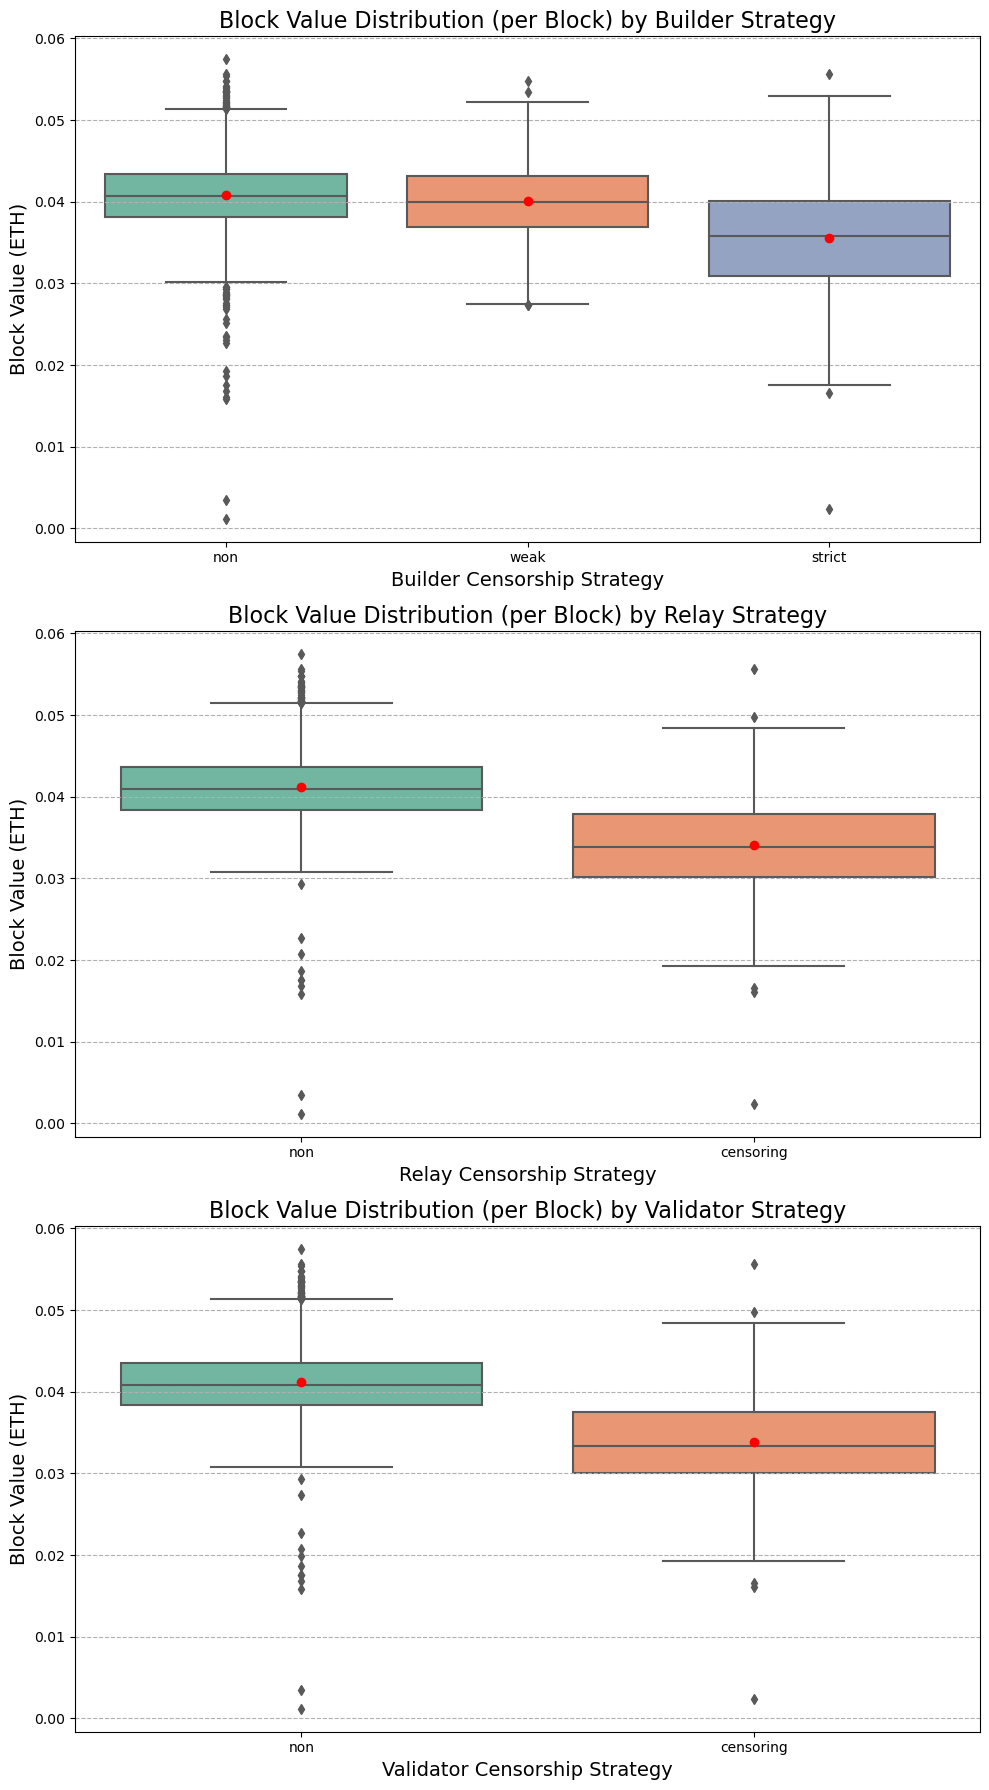

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    # Convert all node ID fields to string and remove extra whitespace
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

blocks_censor = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv"
)

# Compute per-run mean block value for each censorship strategy (ignoring node-level differences)
def calculate_policy_level_mean(df, policy_field):
    policy_mean = df.groupby(['run_id', policy_field])['total_priority_fee'].mean().reset_index()
    return policy_mean

# Compute per-run standard deviation of block value for each strategy
def calculate_policy_level_std(df, policy_field):
    policy_std = df.groupby(['run_id', policy_field])['total_priority_fee'].std().reset_index()
    return policy_std

# Builder strategy
builder_policy_values = calculate_policy_level_mean(blocks_censor, 'builder_policy')
builder_policy_std = calculate_policy_level_std(blocks_censor, 'builder_policy')

# Relay strategy
relay_policy_values = calculate_policy_level_mean(blocks_censor, 'selected_relay_policy')
relay_policy_std = calculate_policy_level_std(blocks_censor, 'selected_relay_policy')

# Validator strategy
blocks_censor['proposer_validator_is_censoring'] = blocks_censor['proposer_validator_is_censoring'].map({True: 'censoring', False: 'non'})
validator_policy_values = calculate_policy_level_mean(blocks_censor, 'proposer_validator_is_censoring')
validator_policy_std = calculate_policy_level_std(blocks_censor, 'proposer_validator_is_censoring')

# Aggregate average and standard deviation across all runs
def aggregate_across_runs(mean_stats, std_stats, policy_field):
    mean_df = mean_stats.groupby(policy_field)['total_priority_fee'].mean().reset_index(name='mean')
    std_df = std_stats.groupby(policy_field)['total_priority_fee'].mean().reset_index(name='mean_std')
    final_stats = pd.merge(mean_df, std_df, on=policy_field)
    return final_stats

builder_final_stats = aggregate_across_runs(builder_policy_values, builder_policy_std, 'builder_policy')
relay_final_stats = aggregate_across_runs(relay_policy_values, relay_policy_std, 'selected_relay_policy')
validator_final_stats = aggregate_across_runs(validator_policy_values, validator_policy_std, 'proposer_validator_is_censoring')


# Convert unit to ETH
for df in [builder_final_stats, relay_final_stats, validator_final_stats]:
    df[['mean', 'mean_std']] *= 1e-9

# Print results
print("Cross-run mean and intra-run std (averaged across runs) of block value (per block) by Builder strategy (ETH):")
print(builder_final_stats)

print("\nCross-run mean and intra-run std (averaged across runs) of block value (per block) by Relay strategy (ETH):")
print(relay_final_stats)

print("\nCross-run mean and intra-run std (averaged across runs) of block value (per block) by Validator strategy (ETH):")
print(validator_final_stats)

# Boxplots: visualize raw block value distribution (with mean marked)
builder_policy_order = ['non', 'weak', 'strict']  
relay_policy_order = ['non', 'censoring']  
validator_policy_order = ['non', 'censoring']  

plt.figure(figsize=(10, 18))

# Builder Boxplot
plt.subplot(3, 1, 1)
sns.boxplot(data=blocks_censor, x='builder_policy', y=blocks_censor['total_priority_fee']*1e-9, palette='Set2', showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"red"}, order=builder_policy_order)
plt.title('Block Value Distribution (per Block) by Builder Strategy', fontsize=16)
plt.ylabel('Block Value (ETH)', fontsize=14)
plt.xlabel('Builder Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')

# Relay Boxplot
plt.subplot(3, 1, 2)
sns.boxplot(data=blocks_censor, x='selected_relay_policy', y=blocks_censor['total_priority_fee']*1e-9, palette='Set2', showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"red"}, order=relay_policy_order)
plt.title('Block Value Distribution (per Block) by Relay Strategy', fontsize=16)
plt.ylabel('Block Value (ETH)', fontsize=14)
plt.xlabel('Relay Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')

# Validator Boxplot
plt.subplot(3, 1, 3)
sns.boxplot(data=blocks_censor, x='proposer_validator_is_censoring', y=blocks_censor['total_priority_fee']*1e-9, palette='Set2', showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"red"}, order=validator_policy_order)
plt.title('Block Value Distribution (per Block) by Validator Strategy', fontsize=16)
plt.ylabel('Block Value (ETH)', fontsize=14)
plt.xlabel('Validator Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Note: Boxplot means represent the overall average of all block-level data points shown in the plot.
# The printed statistics above represent run-level means (per strategy), then averaged across all runs.
# These two metrics are very close or identical in our simulation.


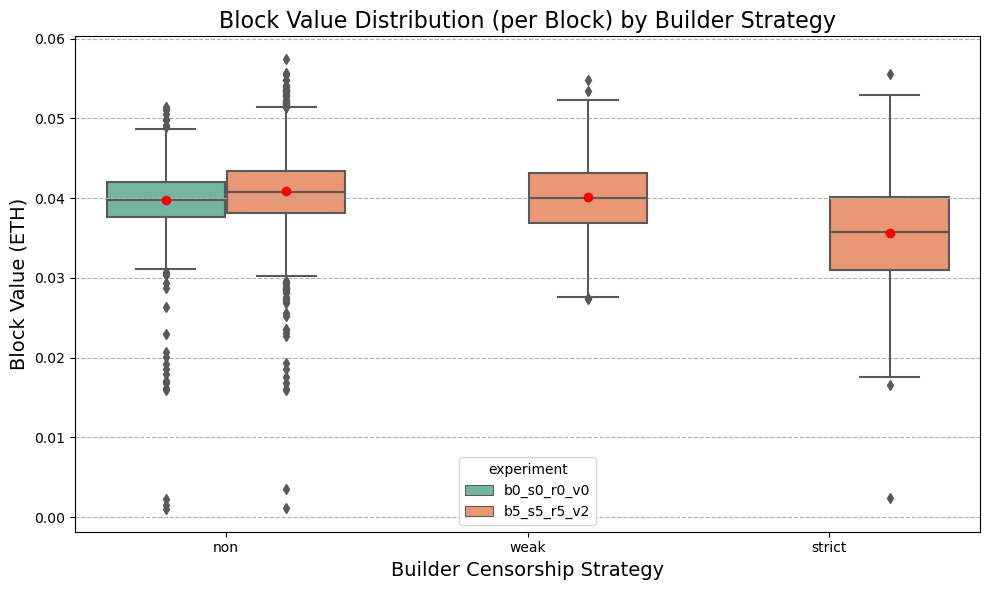

experiment   builder_policy
b0_s0_r0_v0  non               0.039725
b5_s5_r5_v2  non               0.040875
             strict            0.035595
             weak              0.040094
Name: total_priority_fee, dtype: float64


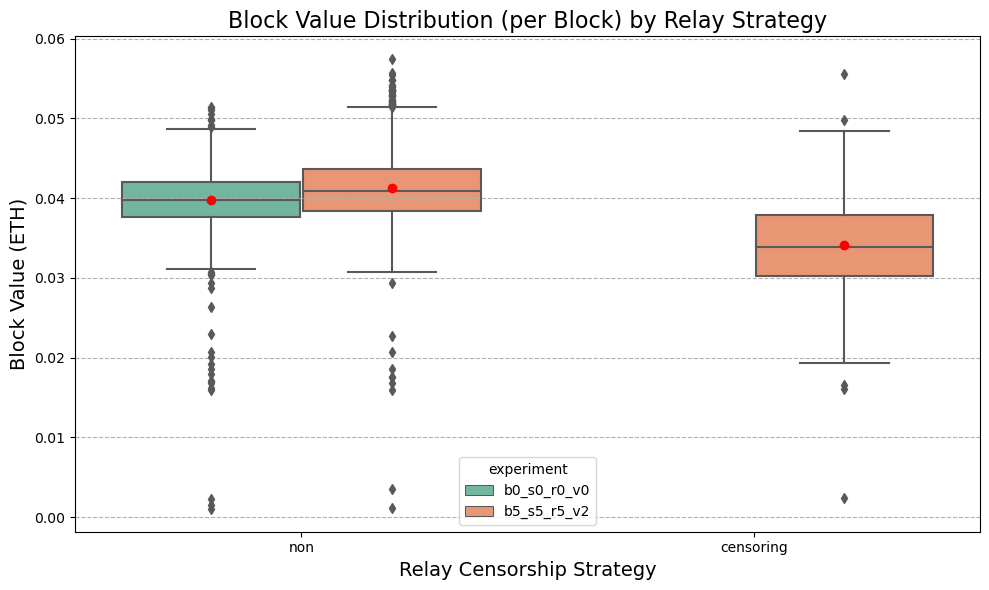

experiment   selected_relay_policy
b0_s0_r0_v0  non                      0.039725
b5_s5_r5_v2  censoring                0.034066
             non                      0.041216
Name: total_priority_fee, dtype: float64


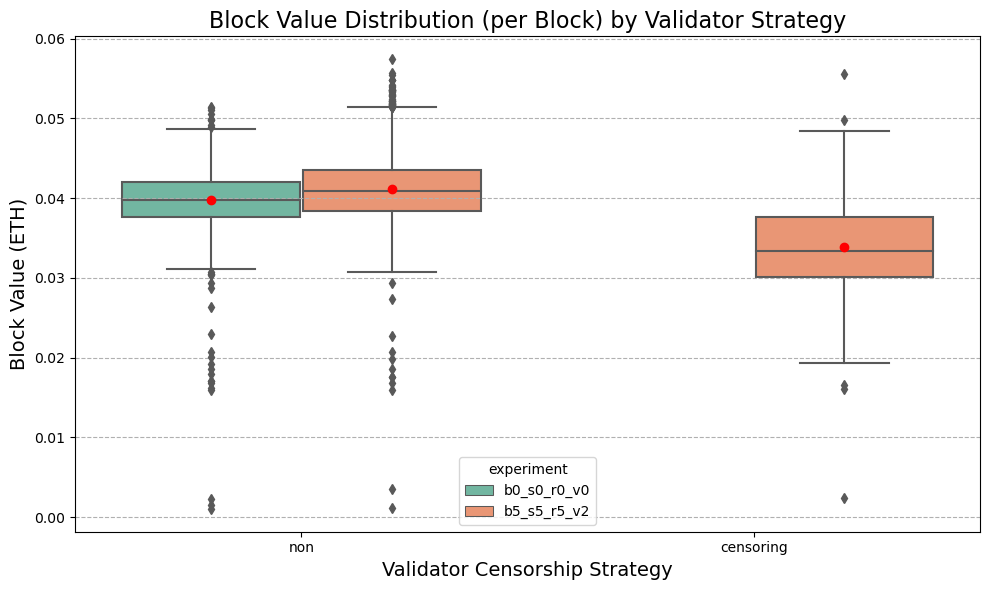

experiment   proposer_validator_policy
b0_s0_r0_v0  non                          0.039725
b5_s5_r5_v2  censoring                    0.033830
             non                          0.041155
Name: total_priority_fee, dtype: float64


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    # Convert all node ID fields to string and remove whitespace
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

# Load data from two experiments for comparison
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)
blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

# Combine both datasets
blocks_all = pd.concat([blocks1, blocks2], ignore_index=True)

blocks_all['proposer_validator_policy'] = blocks_all['proposer_validator_is_censoring'].map({False: 'non', True: 'censoring'})

# Define plotting order
builder_policy_order = ['non', 'weak', 'strict']
relay_policy_order = ['non', 'censoring']
validator_policy_order = ['non', 'censoring']

# Builder
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=blocks_all,
    x='builder_policy',
    y=blocks_all['total_priority_fee'] * 1e-9,
    hue='experiment',
    order=builder_policy_order,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Block Value Distribution (per Block) by Builder Strategy', fontsize=16)
plt.ylabel('Block Value (ETH)', fontsize=14)
plt.xlabel('Builder Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(blocks_all.groupby(['experiment', 'builder_policy'])['total_priority_fee'].mean() * 1e-9)



# Relay
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=blocks_all,
    x='selected_relay_policy',
    y=blocks_all['total_priority_fee'] * 1e-9,
    hue='experiment',
    order=relay_policy_order,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Block Value Distribution (per Block) by Relay Strategy', fontsize=16)
plt.ylabel('Block Value (ETH)', fontsize=14)
plt.xlabel('Relay Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(blocks_all.groupby(['experiment', 'selected_relay_policy'])['total_priority_fee'].mean() * 1e-9)



# Validator
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=blocks_all,
    x='proposer_validator_policy',
    y=blocks_all['total_priority_fee'] * 1e-9,
    hue='experiment',
    order=validator_policy_order,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Block Value Distribution (per Block) by Validator Strategy', fontsize=16)
plt.ylabel('Block Value (ETH)', fontsize=14)
plt.xlabel('Validator Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(blocks_all.groupby(['experiment', 'proposer_validator_policy'])['total_priority_fee'].mean() * 1e-9)

# Note: Means shown in boxplots are computed over all individual block-level data points.
# The printed values below each plot are also calculated from the raw block-level data.


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    # Standardize all node ID data types to strings and strip spaces
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

blocks_censor = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv"
)

# Automatically count the number of nodes by strategy based on actual data
num_builders_by_policy = blocks_censor.groupby('builder_policy')['builder_id'].nunique().to_dict()
num_relays_by_policy = blocks_censor.groupby('selected_relay_policy')['selected_relay_id'].nunique().to_dict()
num_validators_by_policy = blocks_censor.groupby('proposer_validator_is_censoring')['proposer_validator_id'].nunique().to_dict()

# Total block value per node
def node_level_stats_sum(df, node_field):
    return df.groupby(['run_id', node_field])['total_priority_fee'].sum().reset_index()

# Builder node computation
builder_node_values = node_level_stats_sum(blocks_censor, 'builder_id')
builder_policy_mapping = blocks_censor[['builder_id', 'builder_policy']].drop_duplicates()
builder_node_values = pd.merge(builder_node_values, builder_policy_mapping, on='builder_id')

# Relay node computation
relay_node_values = node_level_stats_sum(blocks_censor, 'selected_relay_id')
relay_policy_mapping = blocks_censor[['selected_relay_id', 'selected_relay_policy']].drop_duplicates()
relay_node_values = pd.merge(relay_node_values, relay_policy_mapping, on='selected_relay_id')

# Validator node computation
validator_node_values = node_level_stats_sum(blocks_censor, 'proposer_validator_id')
validator_policy_mapping = blocks_censor[['proposer_validator_id', 'proposer_validator_is_censoring']].drop_duplicates()
validator_node_values = pd.merge(validator_node_values, validator_policy_mapping, on='proposer_validator_id')

# Calculate mean and std for each run (for each strategy)
def calculate_run_level_stats(df, policy_field):
    stats = df.groupby(['run_id', policy_field])['total_priority_fee'].agg(['mean', 'std']).reset_index()
    return stats

builder_run_stats = calculate_run_level_stats(builder_node_values, 'builder_policy')
relay_run_stats = calculate_run_level_stats(relay_node_values, 'selected_relay_policy')
validator_run_stats = calculate_run_level_stats(validator_node_values, 'proposer_validator_is_censoring')

# Compute the mean of means and mean of stds across runs
def aggregate_across_runs(run_stats, policy_field):
    final_stats = run_stats.groupby(policy_field).agg({
        'mean': 'mean',  # Mean of run-level means across runs
        'std': 'mean'    # Mean of run-level stds across runs
    }).reset_index()
    return final_stats

builder_final_stats = aggregate_across_runs(builder_run_stats, 'builder_policy')
relay_final_stats = aggregate_across_runs(relay_run_stats, 'selected_relay_policy')
validator_final_stats = aggregate_across_runs(validator_run_stats, 'proposer_validator_is_censoring')

# Unit conversion (ETH)
for df in [builder_final_stats, relay_final_stats, validator_final_stats]:
    df[['mean', 'std']] *= 1e-9

# Print results
print("Cross-run mean and standard deviation of block value (per node) by builder strategy:")
print(builder_final_stats)

print("\nCross-run mean and standard deviation of block value (per node) per relay strategy:")
print(relay_final_stats)

validator_final_stats['proposer_validator_is_censoring'] = validator_final_stats['proposer_validator_is_censoring'].map({True: 'censoring', False: 'non'})
print("\nCross-run mean and standard deviation of block value (per node) per validator strategy:")
print(validator_final_stats)



Cross-run mean and standard deviation of block value (per node) by builder strategy:
  builder_policy      mean      std
0            non  0.595475  0.14709

Cross-run mean and standard deviation of block value (per node) per relay strategy:
  selected_relay_policy     mean       std
0                   non  1.19095  0.512625

Cross-run mean and standard deviation of block value (per node) per validator strategy:
  proposer_validator_is_censoring     mean       std
0                             non  1.19095  0.235245


Cross-run average and standard deviation of block value (per node) by builder strategy:
  builder_policy      mean       std
0            non  0.878401  0.215579
1         strict  0.437109  0.186806
2           weak  0.191669  0.106807

Cross-run average and standard deviation of block value (per node) by relay strategy:
  selected_relay_policy      mean       std
0             censoring  0.423776  0.207438
1                   non  1.957774  0.691653

Cross-run average and standard deviation of block value (per node) by validator strategy:
  proposer_validator_is_censoring      mean       std
0                             non  1.242359  0.250312
1                       censoring  0.984439  0.135835


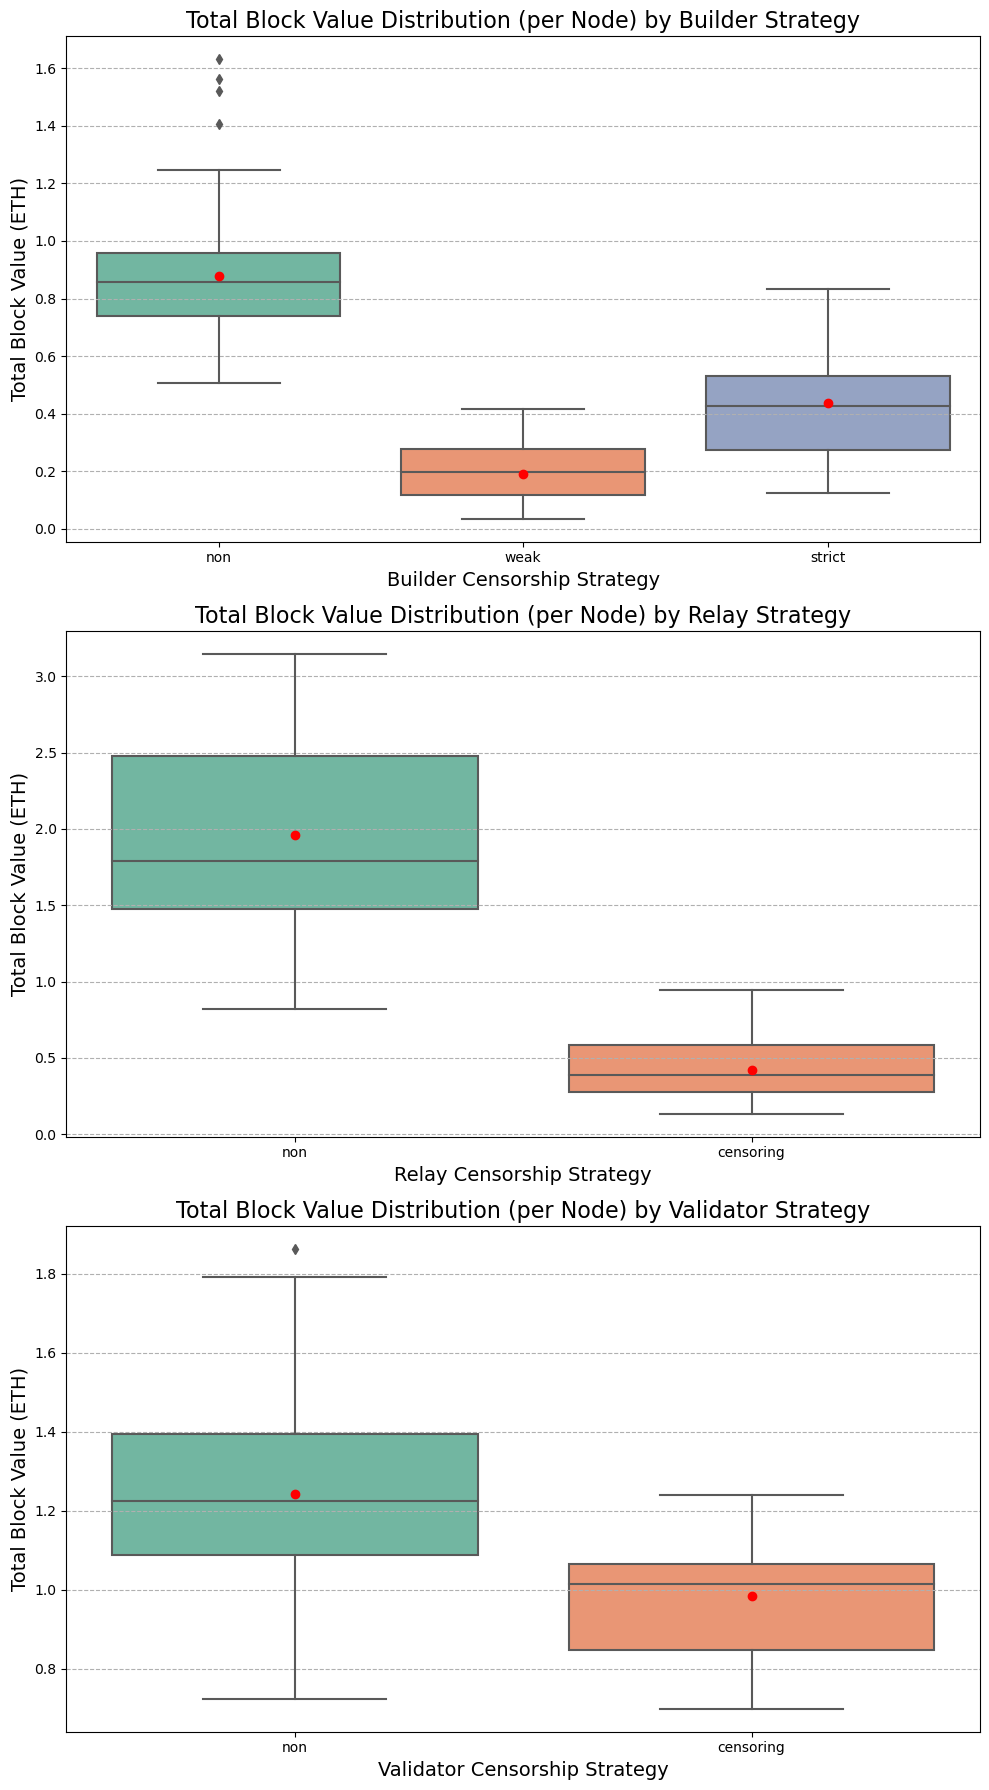

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    # Standardize all node IDs as strings and strip whitespace
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

blocks_censor = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv"
)

# Automatically count the number of nodes by policy from actual data
num_builders_by_policy = blocks_censor.groupby('builder_policy')['builder_id'].nunique().to_dict()
num_relays_by_policy = blocks_censor.groupby('selected_relay_policy')['selected_relay_id'].nunique().to_dict()
num_validators_by_policy = blocks_censor.groupby('proposer_validator_is_censoring')['proposer_validator_id'].nunique().to_dict()

# Calculate total block value per node
def node_level_stats_sum(df, node_field):
    return df.groupby(['run_id', node_field])['total_priority_fee'].sum().reset_index()

# Builder node calculation
builder_node_values = node_level_stats_sum(blocks_censor, 'builder_id')
builder_policy_mapping = blocks_censor[['builder_id', 'builder_policy']].drop_duplicates()
builder_node_values = pd.merge(builder_node_values, builder_policy_mapping, on='builder_id')

# Relay node calculation
relay_node_values = node_level_stats_sum(blocks_censor, 'selected_relay_id')
relay_policy_mapping = blocks_censor[['selected_relay_id', 'selected_relay_policy']].drop_duplicates()
relay_node_values = pd.merge(relay_node_values, relay_policy_mapping, on='selected_relay_id')

# Validator node calculation
validator_node_values = node_level_stats_sum(blocks_censor, 'proposer_validator_id')
validator_policy_mapping = blocks_censor[['proposer_validator_id', 'proposer_validator_is_censoring']].drop_duplicates()
validator_node_values = pd.merge(validator_node_values, validator_policy_mapping, on='proposer_validator_id')

# Compute mean and std within each run by policy
def calculate_run_level_stats(df, policy_field):
    stats = df.groupby(['run_id', policy_field])['total_priority_fee'].agg(['mean', 'std']).reset_index()
    return stats

builder_run_stats = calculate_run_level_stats(builder_node_values, 'builder_policy')
relay_run_stats = calculate_run_level_stats(relay_node_values, 'selected_relay_policy')
validator_run_stats = calculate_run_level_stats(validator_node_values, 'proposer_validator_is_censoring')

# Aggregate mean and std across runs
def aggregate_across_runs(run_stats, policy_field):
    final_stats = run_stats.groupby(policy_field).agg({
        'mean': 'mean',  # Mean of run-level means
        'std': 'mean'    # Mean of run-level standard deviations
    }).reset_index()
    return final_stats

builder_final_stats = aggregate_across_runs(builder_run_stats, 'builder_policy')
relay_final_stats = aggregate_across_runs(relay_run_stats, 'selected_relay_policy')
validator_final_stats = aggregate_across_runs(validator_run_stats, 'proposer_validator_is_censoring')

# Unit conversion (to ETH)
for df in [builder_final_stats, relay_final_stats, validator_final_stats]:
    df[['mean', 'std']] *= 1e-9

# Print results
print("Cross-run average and standard deviation of block value (per node) by builder strategy:")
print(builder_final_stats)

print("\nCross-run average and standard deviation of block value (per node) by relay strategy:")
print(relay_final_stats)

validator_final_stats['proposer_validator_is_censoring'] = validator_final_stats['proposer_validator_is_censoring'].map({True: 'censoring', False: 'non'})
print("\nCross-run average and standard deviation of block value (per node) by validator strategy:")
print(validator_final_stats)

# Define plotting order
builder_policy_order = ['non', 'weak', 'strict']  
relay_policy_order = ['non', 'censoring']  
validator_policy_order = ['non', 'censoring']  

# Convert validator policy field to string if not already
validator_node_values['proposer_validator_is_censoring'] = validator_node_values['proposer_validator_is_censoring'].map({True: 'censoring', False: 'non'})


plt.figure(figsize=(10, 18))

# Builder boxplot
plt.subplot(3, 1, 1)
sns.boxplot(
    data=builder_node_values,
    x='builder_policy',
    y=builder_node_values['total_priority_fee'] * 1e-9,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"},
    order=builder_policy_order 
)
plt.title('Total Block Value Distribution (per Node) by Builder Strategy', fontsize=16)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.xlabel('Builder Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')

# Relay boxplot
plt.subplot(3, 1, 2)
sns.boxplot(
    data=relay_node_values,
    x='selected_relay_policy',
    y=relay_node_values['total_priority_fee'] * 1e-9,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"},
    order=relay_policy_order  
)
plt.title('Total Block Value Distribution (per Node) by Relay Strategy', fontsize=16)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.xlabel('Relay Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')

# Validator boxplot
plt.subplot(3, 1, 3)
sns.boxplot(
    data=validator_node_values,
    x='proposer_validator_is_censoring',
    y=validator_node_values['total_priority_fee'] * 1e-9,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"},
    order=validator_policy_order  
)
plt.title('Total Block Value Distribution (per Node) by Validator Strategy', fontsize=16)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.xlabel('Validator Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Note:
# The mean shown in boxplots is computed from all data points (e.g., per node per run).
# In contrast, the printed mean values are first averaged by run_id and policy, then averaged across all runs.
# The two metrics are very close or identical in our simulation.

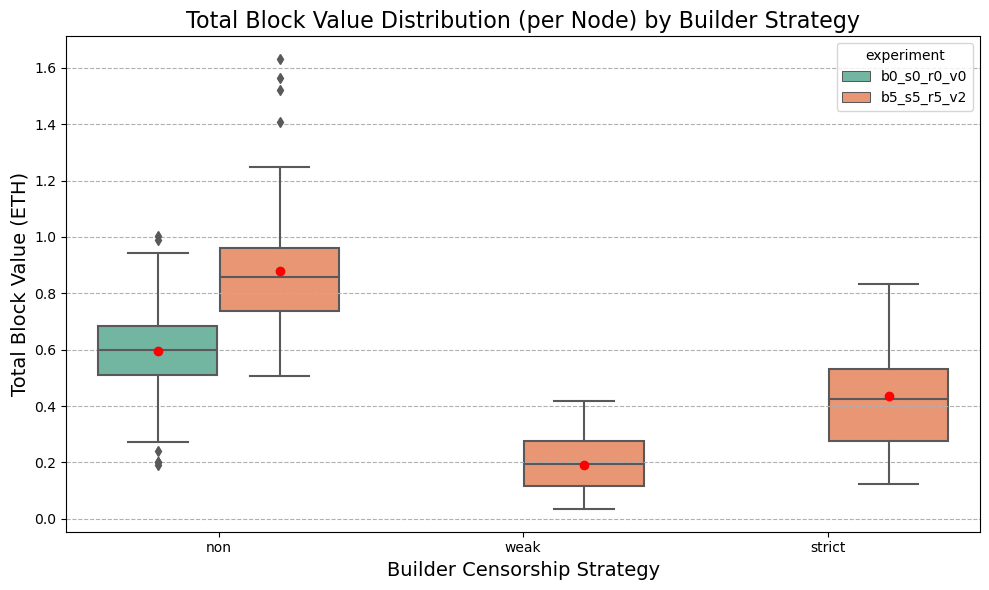

experiment   builder_policy
b0_s0_r0_v0  non               0.595475
b5_s5_r5_v2  non               0.878401
             strict            0.437109
             weak              0.191469
Name: total_priority_fee, dtype: float64


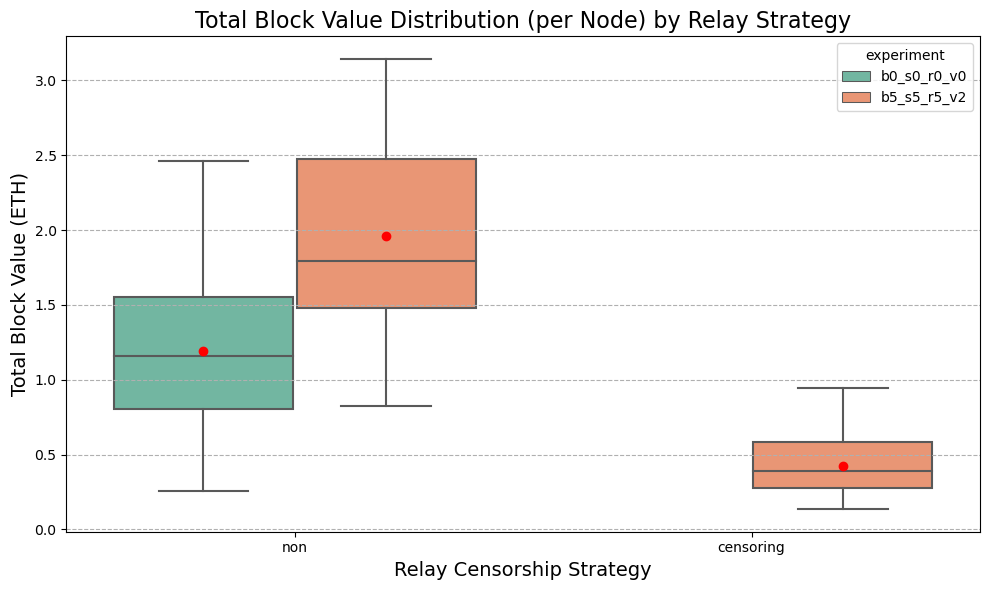

experiment   selected_relay_policy
b0_s0_r0_v0  non                      1.190950
b5_s5_r5_v2  censoring                0.423776
             non                      1.957774
Name: total_priority_fee, dtype: float64


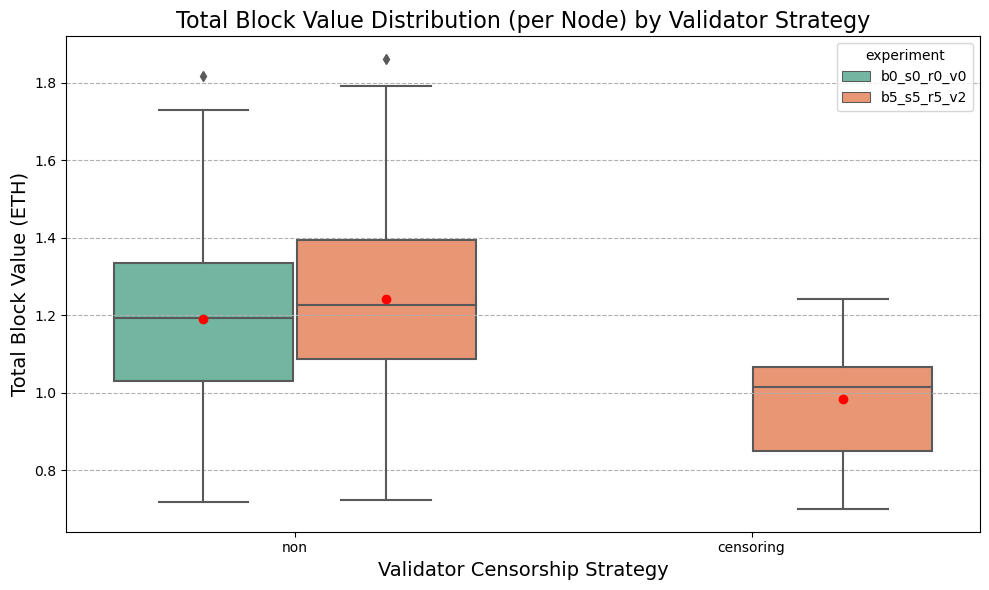

experiment   proposer_validator_policy
b0_s0_r0_v0  non                          1.190950
b5_s5_r5_v2  censoring                    0.984439
             non                          1.242359
Name: total_priority_fee, dtype: float64


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

# Load data from two experiments
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)
blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

# Merge both datasets
blocks = pd.concat([blocks1, blocks2], ignore_index=True)
blocks['proposer_validator_policy'] = blocks['proposer_validator_is_censoring'].map({False: 'non', True: 'censoring'})

def node_level_stats_sum(df, node_field):
    return df.groupby(['experiment', 'run_id', node_field])['total_priority_fee'].sum().reset_index()

def node_level_stats_sum_with_policy(df, node_field, policy_field):
    return df.groupby(['experiment', 'run_id', node_field, policy_field])['total_priority_fee'].sum().reset_index()

# builder
builder_node_values = node_level_stats_sum(blocks, 'builder_id')
builder_policy_mapping = blocks[['builder_id', 'builder_policy', 'experiment']].drop_duplicates()
builder_node_values = pd.merge(builder_node_values, builder_policy_mapping, on=['builder_id', 'experiment'])

# relay
relay_node_values = node_level_stats_sum(blocks, 'selected_relay_id')
relay_policy_mapping = blocks[['selected_relay_id', 'selected_relay_policy', 'experiment']].drop_duplicates()
relay_node_values = pd.merge(relay_node_values, relay_policy_mapping, on=['selected_relay_id', 'experiment'])

# validator
validator_node_values = node_level_stats_sum_with_policy(blocks, 'proposer_validator_id', 'proposer_validator_policy')
validator_policy_mapping = blocks[['proposer_validator_id', 'proposer_validator_policy', 'experiment']].drop_duplicates()
validator_node_values = pd.merge(validator_node_values, validator_policy_mapping, on=['proposer_validator_id', 'experiment', 'proposer_validator_policy'])

# Define plotting order for each policy
builder_policy_order = ['non', 'weak', 'strict']
relay_policy_order = ['non', 'censoring']
validator_policy_order = ['non', 'censoring']

# Plotting boxplots

# Builder
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=builder_node_values,
    x='builder_policy',
    y=builder_node_values['total_priority_fee'] * 1e-9,
    hue='experiment',
    order=builder_policy_order,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Total Block Value Distribution (per Node) by Builder Strategy', fontsize=16)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.xlabel('Builder Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(builder_node_values.groupby(['experiment', 'builder_policy'])['total_priority_fee'].mean() * 1e-9)



# Relay
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=relay_node_values,
    x='selected_relay_policy',
    y=relay_node_values['total_priority_fee'] * 1e-9,
    hue='experiment',
    order=relay_policy_order,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Total Block Value Distribution (per Node) by Relay Strategy', fontsize=16)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.xlabel('Relay Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(relay_node_values.groupby(['experiment', 'selected_relay_policy'])['total_priority_fee'].mean() * 1e-9)


# Validator
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=validator_node_values,
    x='proposer_validator_policy',
    y=validator_node_values['total_priority_fee'] * 1e-9,
    hue='experiment',
    order=validator_policy_order,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Total Block Value Distribution (per Node) by Validator Strategy', fontsize=16)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.xlabel('Validator Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(validator_node_values.groupby(['experiment', 'proposer_validator_policy'])['total_priority_fee'].mean() * 1e-9)


# Note: Means shown in boxplots are computed over all individual block-level data points.
# The printed values below each plot are also calculated from the raw block-level data.


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

blocks_censor = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv"
)

# Accumulated builder_profit and proposer_profit values per node
def node_level_profit_sum(df, node_field, profit_field):
    return df.groupby(['run_id', node_field])[profit_field].sum().reset_index()

# Calculate builder node profit
builder_node_profits = node_level_profit_sum(blocks_censor, 'builder_id', 'builder_profit')
builder_policy_mapping = blocks_censor[['builder_id', 'builder_policy']].drop_duplicates()
builder_node_profits = pd.merge(builder_node_profits, builder_policy_mapping, on='builder_id')

# Calculate validator node profit
validator_node_profits = node_level_profit_sum(blocks_censor, 'proposer_validator_id', 'proposer_profit')
validator_policy_mapping = blocks_censor[['proposer_validator_id', 'proposer_validator_is_censoring']].drop_duplicates()
validator_node_profits = pd.merge(validator_node_profits, validator_policy_mapping, on='proposer_validator_id')

# Compute mean and std per strategy within each run
def calculate_run_level_stats(df, policy_field, profit_field):
    stats = df.groupby(['run_id', policy_field])[profit_field].agg(['mean', 'std']).reset_index()
    return stats

builder_run_stats = calculate_run_level_stats(builder_node_profits, 'builder_policy', 'builder_profit')
validator_run_stats = calculate_run_level_stats(validator_node_profits, 'proposer_validator_is_censoring', 'proposer_profit')

# Aggregate mean and std values across runs
def aggregate_across_runs(run_stats, policy_field):
    final_stats = run_stats.groupby(policy_field).agg({
        'mean': 'mean',  # Mean of means across runs
        'std': 'mean'    # Mean of std deviations across runs
    }).reset_index()
    return final_stats

builder_final_stats = aggregate_across_runs(builder_run_stats, 'builder_policy')
validator_final_stats = aggregate_across_runs(validator_run_stats, 'proposer_validator_is_censoring')

# Unit conversion to ETH
for df in [builder_final_stats, validator_final_stats]:
    df[['mean', 'std']] *= 1e-9

# Print results
print("Mean and standard deviation of builder profit (per node) by censorship strategy across runs:")
print(builder_final_stats)

validator_final_stats['proposer_validator_is_censoring'] = validator_final_stats['proposer_validator_is_censoring'].map({True: 'censoring', False: 'non'})
print("\nMean and standard deviation of validator profit (per node) by censorship strategy across runs:")
print(validator_final_stats)

Mean and standard deviation of builder profit (per node) by censorship strategy across runs:
  builder_policy      mean       std
0            non  0.029774  0.007355

Mean and standard deviation of validator profit (per node) by censorship strategy across runs:
  proposer_validator_is_censoring      mean       std
0                             non  1.131402  0.223483


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

blocks_censor = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv"
)

# Accumulated builder_profit and proposer_profit values per node
def node_level_profit_sum(df, node_field, profit_field):
    return df.groupby(['run_id', node_field])[profit_field].sum().reset_index()

# Calculate builder node profit
builder_node_profits = node_level_profit_sum(blocks_censor, 'builder_id', 'builder_profit')
builder_policy_mapping = blocks_censor[['builder_id', 'builder_policy']].drop_duplicates()
builder_node_profits = pd.merge(builder_node_profits, builder_policy_mapping, on='builder_id')

# Calculate validator node profit
validator_node_profits = node_level_profit_sum(blocks_censor, 'proposer_validator_id', 'proposer_profit')
validator_policy_mapping = blocks_censor[['proposer_validator_id', 'proposer_validator_is_censoring']].drop_duplicates()
validator_node_profits = pd.merge(validator_node_profits, validator_policy_mapping, on='proposer_validator_id')

# Compute mean and std per strategy within each run
def calculate_run_level_stats(df, policy_field, profit_field):
    stats = df.groupby(['run_id', policy_field])[profit_field].agg(['mean', 'std']).reset_index()
    return stats

builder_run_stats = calculate_run_level_stats(builder_node_profits, 'builder_policy', 'builder_profit')
validator_run_stats = calculate_run_level_stats(validator_node_profits, 'proposer_validator_is_censoring', 'proposer_profit')

# Aggregate mean and std values across runs
def aggregate_across_runs(run_stats, policy_field):
    final_stats = run_stats.groupby(policy_field).agg({
        'mean': 'mean', 
        'std': 'mean'   
    }).reset_index()
    return final_stats

builder_final_stats = aggregate_across_runs(builder_run_stats, 'builder_policy')
validator_final_stats = aggregate_across_runs(validator_run_stats, 'proposer_validator_is_censoring')

# Unit conversion to ETH
for df in [builder_final_stats, validator_final_stats]:
    df[['mean', 'std']] *= 1e-9

# Print results
print("Mean and standard deviation of builder profit (per node) by censorship strategy across runs:")
print(builder_final_stats)

validator_final_stats['proposer_validator_is_censoring'] = validator_final_stats['proposer_validator_is_censoring'].map({True: 'censoring', False: 'non'})
print("\nMean and standard deviation of validator profit (per node) by censorship strategy across runs:")
print(validator_final_stats)

Mean and standard deviation of builder profit (per node) by censorship strategy across runs:
  builder_policy      mean       std
0            non  0.043920  0.010779
1         strict  0.021855  0.009340
2           weak  0.009583  0.005340

Mean and standard deviation of validator profit (per node) by censorship strategy across runs:
  proposer_validator_is_censoring      mean       std
0                             non  1.180241  0.237796
1                       censoring  0.935217  0.129043


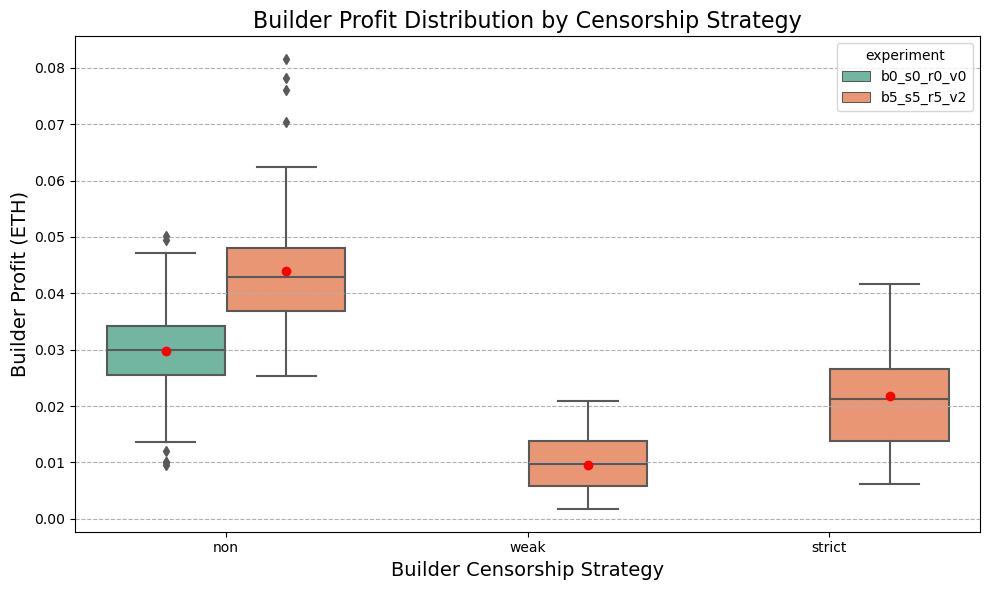

experiment   builder_policy
b0_s0_r0_v0  non               0.029774
b5_s5_r5_v2  non               0.043920
             strict            0.021855
             weak              0.009573
Name: builder_profit, dtype: float64


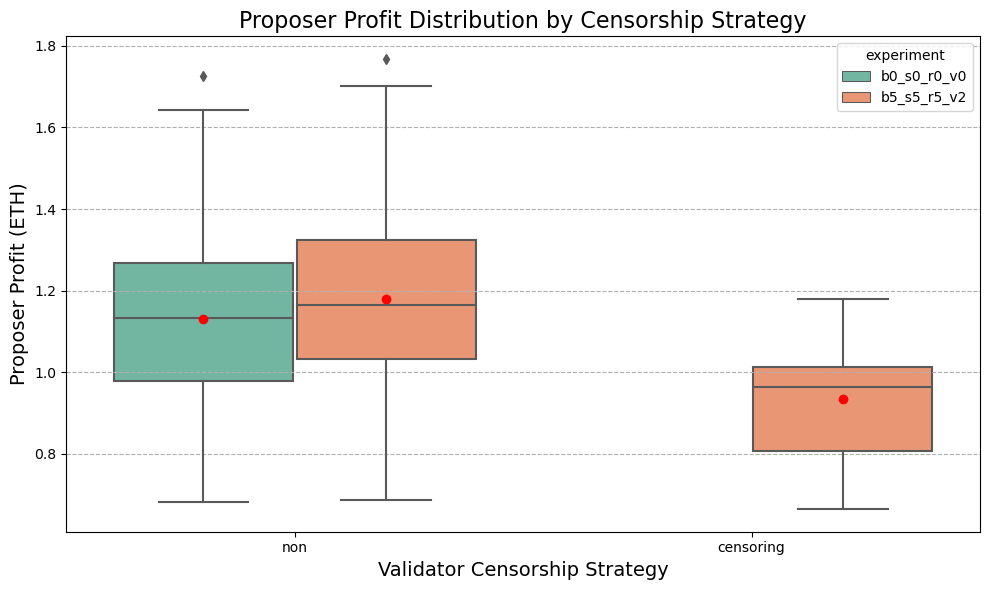

experiment   proposer_validator_policy
b0_s0_r0_v0  non                          1.131402
b5_s5_r5_v2  censoring                    0.935217
             non                          1.180241
Name: proposer_profit, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    if tag is not None:
        df['experiment'] = tag
    
    return df

# Load data from two experiments for comparison
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)
blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

# Merge both datasets
blocks = pd.concat([blocks1, blocks2], ignore_index=True)
blocks['proposer_validator_policy'] = blocks['proposer_validator_is_censoring'].map({False: 'non', True: 'censoring'})

builder_node_values = blocks.groupby(['experiment', 'run_id', 'builder_id', 'builder_policy'])['builder_profit'].sum().reset_index()
validator_node_values = blocks.groupby(['experiment', 'run_id', 'proposer_validator_id', 'proposer_validator_policy'])['proposer_profit'].sum().reset_index()

builder_policy_order = ['non', 'weak', 'strict']
validator_policy_order = ['non', 'censoring']

# Builder
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=builder_node_values,
    x='builder_policy',
    y=builder_node_values['builder_profit'] * 1e-9,
    hue='experiment',
    order=builder_policy_order,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Builder Profit Distribution by Censorship Strategy', fontsize=16)
plt.ylabel('Builder Profit (ETH)', fontsize=14)
plt.xlabel('Builder Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print(builder_node_values.groupby(['experiment', 'builder_policy'])['builder_profit'].mean() * 1e-9)


# Proposer
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=validator_node_values,
    x='proposer_validator_policy',
    y=validator_node_values['proposer_profit'] * 1e-9,
    hue='experiment',
    order=validator_policy_order,
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Proposer Profit Distribution by Censorship Strategy', fontsize=16)
plt.ylabel('Proposer Profit (ETH)', fontsize=14)
plt.xlabel('Validator Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print(validator_node_values.groupby(['experiment', 'proposer_validator_policy'])['proposer_profit'].mean() * 1e-9)

# Note: Means shown in boxplots are computed over all individual block-level data points.
# The printed values below each plot are also calculated from the raw block-level data.



#### Number and Proportion of Empty Blocks

Average number and ratio of empty blocks per run for each experiment:
    experiment  empty_blocks_count  empty_block_ratio
0  b0_s0_r0_v0                 0.2           0.000667
1  b5_s5_r5_v2                 0.3           0.001000


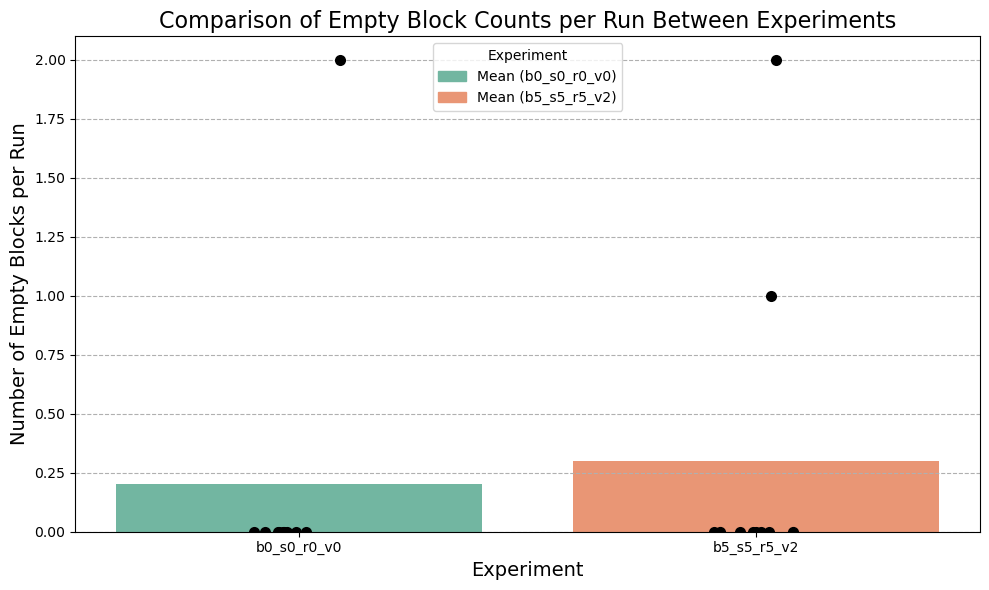


Data used for plotting (combined_counts_ratios):
        run_id  empty_blocks_count  empty_block_ratio   experiment
run_id                                                            
1            1                   0           0.000000  b0_s0_r0_v0
2            2                   0           0.000000  b0_s0_r0_v0
3            3                   0           0.000000  b0_s0_r0_v0
4            4                   0           0.000000  b0_s0_r0_v0
5            5                   0           0.000000  b0_s0_r0_v0
6            6                   0           0.000000  b0_s0_r0_v0
7            7                   2           0.006667  b0_s0_r0_v0
8            8                   0           0.000000  b0_s0_r0_v0
9            9                   0           0.000000  b0_s0_r0_v0
10          10                   0           0.000000  b0_s0_r0_v0
1            1                   0           0.000000  b5_s5_r5_v2
2            2                   0           0.000000  b5_s5_r5_v2
3           

In [ ]:

import numpy as np
import matplotlib.patches as mpatches

# Load data
blocks1_original = pd.read_csv("simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv")
blocks2_original = pd.read_csv("simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv")

# Count and ratio of empty blocks per run
def calculate_empty_block_counts_ratios(blocks, experiment_name):
    all_run_ids = blocks['run_id'].unique()

    empty_blocks_per_run = blocks[blocks['builder_id'] == "PROPOSER"].groupby('run_id').size().reindex(all_run_ids, fill_value=0)
    total_proposed_blocks_per_run = blocks[blocks['is_proposed']].groupby('run_id').size().reindex(all_run_ids, fill_value=0)
    
    empty_block_ratio = empty_blocks_per_run / total_proposed_blocks_per_run

    return pd.DataFrame({
        'run_id': all_run_ids,
        'empty_blocks_count': empty_blocks_per_run,
        'empty_block_ratio': empty_block_ratio,
        'experiment': experiment_name
    })

# Calculate statistics for both experiments
empty_counts_ratios_exp1 = calculate_empty_block_counts_ratios(blocks1_original, 'b0_s0_r0_v0')
empty_counts_ratios_exp2 = calculate_empty_block_counts_ratios(blocks2_original, 'b5_s5_r5_v2')

# Merge data
combined_counts_ratios = pd.concat([empty_counts_ratios_exp1, empty_counts_ratios_exp2])

# Calculate averages
avg_results = combined_counts_ratios.groupby('experiment').agg({
    'empty_blocks_count': 'mean',
    'empty_block_ratio': 'mean'
}).reset_index()

# Display average empty block count and ratio
print("Average number and ratio of empty blocks per run for each experiment:")
print(avg_results)


plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='experiment',
    y='empty_blocks_count',
    data=combined_counts_ratios,
    estimator='mean',
    palette='Set2',
    alpha=1.0,
    ci=None
)

x_positions = {'b0_s0_r0_v0': 0, 'b5_s5_r5_v2': 1}

# Add individual points (stripplot), excluding outliers in selected runs
sns.stripplot(
    x='experiment',
    y='empty_blocks_count',
    data=combined_counts_ratios[~(
        ((combined_counts_ratios['experiment'] == 'b5_s5_r5_v2') &
         (combined_counts_ratios['run_id'].isin([8, 10])))
    )],
    color='black',
    size=8,
    jitter=True
)

# Add manually selected outliers as individual points
exp = 'b5_s5_r5_v2'
y_8 = combined_counts_ratios.query("experiment == @exp and run_id == 8")['empty_blocks_count'].iloc[0]
y_10 = combined_counts_ratios.query("experiment == @exp and run_id == 10")['empty_blocks_count'].iloc[0]
plt.scatter(
    x=x_positions[exp] - 0.08, y=y_8, color='black', s=50, zorder=10
)
plt.scatter(
    x=x_positions[exp] + 0.08, y=y_10, color='black', s=50, zorder=10
)

plt.ylabel('Number of Empty Blocks per Run', fontsize=14)
plt.xlabel('Experiment', fontsize=14)
plt.title('Comparison of Empty Block Counts per Run Between Experiments', fontsize=16)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()


# Manually add legend to explain the bar colors
bar_colors = [bar.get_facecolor() for bar in ax.patches[:2]]
legend_elements = [
    mpatches.Patch(color=bar_colors[0], label='Mean (b0_s0_r0_v0)'),
    mpatches.Patch(color=bar_colors[1], label='Mean (b5_s5_r5_v2)')
]
plt.legend(handles=legend_elements, title='Experiment', loc='upper center')

plt.show()


# Print the data used for plotting
print("\nData used for plotting (combined_counts_ratios):")
print(combined_counts_ratios)